# Data Load

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
from IPython.display import display
import scipy as sp

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

pd.options.display.max_columns = None   # To see the entire columns of dataframes
pd.options.display.max_rows = 100    

In [349]:
train_combat = pd.read_csv("raw/train_combat.csv")
train_payment = pd.read_csv("raw/train_payment.csv")
train_pledge = pd.read_csv("raw/train_pledge.csv")
train_trade = pd.read_csv("raw/train_trade.csv")
train_activity = pd.read_csv("raw/train_activity.csv")
train_label = pd.read_csv("raw/train_label.csv")

In [884]:
# Copy files in case of retrieving the original ones
combat = train_combat.copy()
pledge = train_pledge.copy()
payment = train_payment.copy()
trade = train_trade.copy()
activity = train_activity.copy()

# Data Check

## amount_spent 분포가 상당히 0에 뭉쳐있다 : outlier가 많음!

In [885]:
label = train_label["acc_id"]

In [886]:
train_label.head()

,acc_id,survival_time,amount_spent,total_spent
0,27835,64,0.002559,0.163793
1,12351,64,0.120154,7.689860
2,125437,55,0.182593,10.042642
3,104483,64,0.016241,1.039454
4,4704,20,0.226396,4.527925


In [887]:
train_label.describe()

,acc_id,survival_time,amount_spent,total_spent
count,40000.000000,40000.000000,40000.000000,40000.000000
mean,65281.105550,45.706700,0.124931,3.924948
std,37525.623536,23.265907,0.722272,6.770322
min,2.000000,1.000000,0.000000,0.000000
25%,32792.750000,24.000000,0.000000,0.000000
50%,65359.000000,64.000000,0.020343,0.974357
75%,97685.750000,64.000000,0.106119,4.606581
max,130473.000000,64.000000,39.412632,97.515488


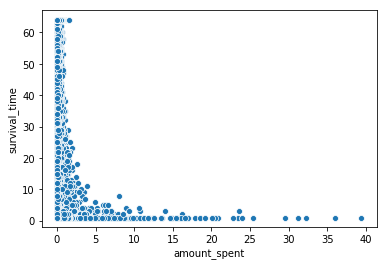

In [888]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.scatterplot(data=train_label,x='amount_spent',y='survival_time')

In [889]:
train_label['amount_spent'].max()

39.41263209871594

In [890]:
train_label['amount_spent'].mean()

0.12493145693483568

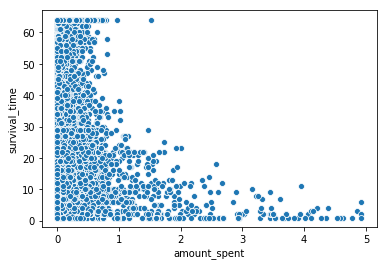

In [891]:
sns.scatterplot(data=train_label[train_label['amount_spent']<5],x='amount_spent',y='survival_time')

In [892]:
train_label[train_label['amount_spent']<5].count()

acc_id           39913
survival_time    39913
amount_spent     39913
total_spent      39913
dtype: int64

## 40000명 중 오직 26명 : 0.065% 사람이 매출의 11% 이상을 차지하고 있음!

In [893]:
train_label[train_label['amount_spent']<15]['amount_spent'].sum()

4431.46608998373

In [894]:
train_label[train_label['amount_spent']<15]['amount_spent'].count()

39974

In [895]:
train_label[train_label['amount_spent']>15]['amount_spent'].sum()

565.7921874097146

In [896]:
train_label[train_label['amount_spent']>15]['amount_spent'].count()

26

In [897]:
train_label[train_label['amount_spent']>15]['amount_spent'].sum() / train_label['amount_spent'].sum()

0.1132205213345167

## 그래프로 시각화

In [898]:
li = []
lid = []
liu = []
lic = []
lir = []
for i in range(1,20):
    li.append(train_label[train_label['amount_spent']>i]['amount_spent'].sum() / train_label['amount_spent'].sum())
    lid.append(train_label[train_label['amount_spent']<i]['amount_spent'].sum())
    liu.append(train_label[train_label['amount_spent']>i]['amount_spent'].sum())
    lic.append(train_label[train_label['amount_spent']>i]['amount_spent'].count())
    lir.append(train_label[train_label['amount_spent']>i]['amount_spent'].count() / train_label['amount_spent'].count())

In [899]:
train_as = pd.DataFrame(columns=['threshold','ratio','down','upper','cratio'])
train_as['threshold'] = np.arange(1,20)
train_as['ratio'] = li
train_as['down'] = lid
train_as['upper'] = liu
train_as['count'] = lic
train_as['cratio'] = lir
train_as.head()

,threshold,ratio,down,upper,cratio,count
0,1,0.374914,3123.716109,1873.542169,0.012025,481
1,2,0.296275,3516.696865,1480.561413,0.005200,208
2,3,0.265533,3670.321576,1326.936702,0.003650,146
3,4,0.236212,3816.844959,1180.413319,0.002600,104
4,5,0.221038,3892.676149,1104.582128,0.002175,87


### 정규화된

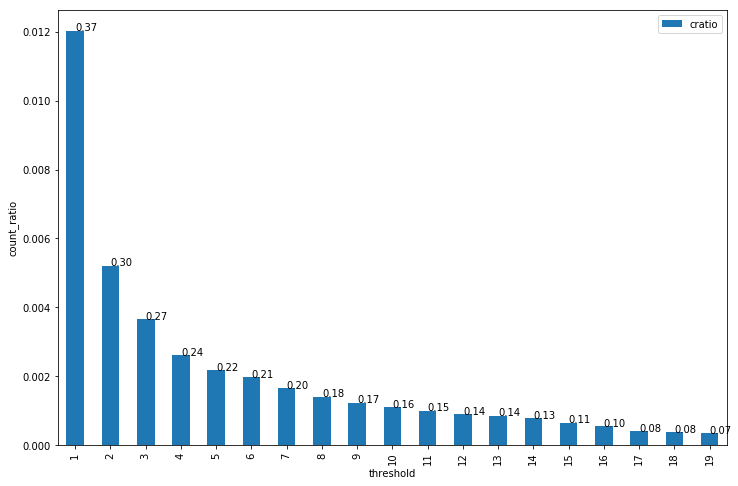

In [900]:
f, ax = plt.subplots(1,1,figsize=(12,8))

# ax.barplot(train_as[['threshold','ratio']].set_index('threshold'))
train_as[['threshold','cratio']].set_index('threshold').plot(kind='bar', ax=ax)
ax.set_xlabel("threshold")
ax.set_ylabel("count_ratio")
for i in range(len(train_as)):
    plt.text(x = train_as['threshold'][i]-1 , y = train_as['cratio'][i], s = "{:.2f}".format(train_as['ratio'][i]), size = 10)


# 하나라도 일단 버리지 말자

# Preprocessing : combat table

In [901]:
combat.head()

,day,acc_id,char_id,server,class,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent
0,1,13809,54861,ap,2,13,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,1,13809,256332,ap,2,13,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,1,13809,307293,ap,3,14,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,1,13809,374964,ap,7,16,0.0,0.0,0.0,0.0,0.0,0.112612,0.098129
4,1,13809,117917,ap,2,11,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [902]:
combat['acc_id'].nunique()

40000

In [903]:
combat['char_id'].nunique()

149247

In [904]:
combat.describe()

,day,acc_id,char_id,class,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent
count,1.574671e+06,1.574671e+06,1.574671e+06,1.574671e+06,1.574671e+06,1.574671e+06,1.574671e+06,1.574671e+06,1.574671e+06,1.574671e+06,1.574671e+06,1.574671e+06
mean,1.476561e+01,6.544376e+04,1.985164e+05,3.098323e+00,1.221995e+01,1.475613e-01,3.975899e-02,1.135964e-01,6.785012e-02,6.167362e-02,1.995034e-01,2.639202e-01
std,8.129315e+00,3.749076e+04,1.146590e+05,2.152838e+00,5.295066e+00,1.066027e+00,8.165007e-01,8.578172e-01,9.801067e-01,1.021016e+00,1.139230e+00,1.107619e+00
min,1.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+00,3.307600e+04,9.900800e+04,1.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.500000e+01,6.557700e+04,1.982620e+05,3.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.200000e+01,9.766600e+04,2.978010e+05,4.000000e+00,1.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.812875e-02
max,2.800000e+01,1.304730e+05,3.974430e+05,7.000000e+00,1.700000e+01,5.622540e+01,2.021548e+02,1.123911e+02,2.604922e+02,2.355672e+02,1.997728e+02,5.455959e+01


In [905]:
combat.count()

day                    1574671
acc_id                 1574671
char_id                1574671
server                 1574671
class                  1574671
level                  1574671
pledge_cnt             1574671
random_attacker_cnt    1574671
random_defender_cnt    1574671
temp_cnt               1574671
same_pledge_cnt        1574671
etc_cnt                1574671
num_opponent           1574671
dtype: int64

In [906]:
combat[combat["acc_id"].isin(label)].count()

day                    1574671
acc_id                 1574671
char_id                1574671
server                 1574671
class                  1574671
level                  1574671
pledge_cnt             1574671
random_attacker_cnt    1574671
random_defender_cnt    1574671
temp_cnt               1574671
same_pledge_cnt        1574671
etc_cnt                1574671
num_opponent           1574671
dtype: int64

In [907]:
# Total amount spent per account the whole period
train_label["total_spent"] = train_label["survival_time"] * train_label["amount_spent"]

In [908]:
combat[combat["acc_id"].isin(label)] # label에 있는 숫자만 골라냄

,day,acc_id,char_id,server,class,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent
0,1,13809,54861,ap,2,13,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,1,13809,256332,ap,2,13,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,1,13809,307293,ap,3,14,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,1,13809,374964,ap,7,16,0.0,0.0,0.0,0.000000,0.0,0.112612,0.098129
4,1,13809,117917,ap,2,11,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574666,10,21604,179760,az,3,15,0.0,0.0,0.0,4.797278,0.0,0.000000,0.098129
1574667,10,73622,36541,az,3,15,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1574668,10,104426,23384,ai,7,6,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1574669,10,85674,111923,an,4,16,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [909]:
# No need to keep the rows whose "acc_id" does not appear in Label data
combat = combat[combat["acc_id"].isin(label)]
pledge = pledge[pledge["acc_id"].isin(label)]
payment = payment[payment["acc_id"].isin(label)]
trade = trade[trade["source_acc_id"].isin(label)]
trade = trade[trade["target_acc_id"].isin(label)]
activity = activity[activity["acc_id"].isin(label)]
# 요렇게 하면 달라지는 게 무엇인가?

## Common Features

In [910]:
# The number of characters per account
all_char = pd.concat([train_combat[["char_id", "acc_id"]], train_pledge[["char_id", "acc_id"]], train_activity[["char_id", "acc_id"]]])
# char_count = all_char.groupby("char_id")["acc_id"].count()
char_count = all_char.groupby("acc_id")["char_id"].nunique()
char_count.head()

acc_id
2     1
5     3
8     7
17    4
20    2
Name: char_id, dtype: int64

In [911]:
all_char.sort_values(by='acc_id')['acc_id'].nunique()

40000

In [912]:
all_char.sort_values(by='acc_id')['char_id'].nunique()

150960

In [913]:
all_char.groupby('acc_id')['char_id'].nunique().head()

acc_id
2     1
5     3
8     7
17    4
20    2
Name: char_id, dtype: int64

In [914]:
all_char[all_char['acc_id']==8]['char_id'].nunique()

7

In [915]:
char_count = pd.DataFrame({"char_count" : char_count})  # in case of merging

In [916]:
all_char.head()
# 전체 char_id에 따른 acc_id 묶어놓은 것!

,char_id,acc_id
0,54861,13809
1,256332,13809
2,307293,13809
3,374964,13809
4,117917,13809


In [917]:
char_count.head()
# 이것의 의미?
# 이거 acc_id가 나와야 하는 것 아님?

,char_count
acc_id,
2,1
5,3
8,7
17,4
20,2


In [918]:
# Find all the unique servers
total_server = pd.concat([train_combat["server"], train_pledge["server"], train_trade["server"], train_activity["server"]])
total_server.head()

0    ap
1    ap
2    ap
3    ap
4    ap
Name: server, dtype: object

In [919]:
server_list = total_server.unique()
server_list

array(['ap', 'am', 'ag', 'ar', 'as', 'ae', 'an', 'az', 'ay', 'bd', 'al',
       'ab', 'av', 'bn', 'ax', 'ai', 'bb', 'aq', 'ad', 'ac', 'bk', 'ak',
       'bl', 'aw', 'aj', 'bm', 'bc', 'at', 'aa', 'bo', 'ao', 'ah', 'au',
       'af', 'bj', 'br', 'bp', 'bg', 'bs', 'bi'], dtype=object)

In [920]:
# Encode servers into integer values
svle = LabelEncoder()
svle.fit(server_list)
for df in [combat, pledge, trade, activity]:
    df["server"] = svle.transform(df["server"])
# server column을 categorial하게 만들어줌!

In [921]:
svle.classes_

array(['aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak',
       'al', 'am', 'an', 'ao', 'ap', 'aq', 'ar', 'as', 'at', 'au', 'av',
       'aw', 'ax', 'ay', 'az', 'bb', 'bc', 'bd', 'bg', 'bi', 'bj', 'bk',
       'bl', 'bm', 'bn', 'bo', 'bp', 'br', 'bs'], dtype=object)

In [922]:
itemtype_list = trade['item_type'].unique()
itemtype_list

array(['enchant_scroll', 'accessory', 'etc', 'adena', 'weapon', 'armor',
       'spell'], dtype=object)

In [923]:
# Encode servers into integer values : item_type (거래한 아이템 종류)
le = LabelEncoder()
le.fit(itemtype_list)
trade['item_type'] =  le.transform(trade['item_type'])
# server column을 categorial하게 만들어줌!

In [924]:
le.classes_

array(['accessory', 'adena', 'armor', 'enchant_scroll', 'etc', 'spell',
       'weapon'], dtype=object)

In [925]:
trade.head()

,day,time,type,server,source_acc_id,source_char_id,target_acc_id,target_char_id,item_type,item_amount,item_price
0,7,21:13:05,1,6,11439,385109,48152,34247,3,4.793968e-08,NaN
2,1,14:24:53,1,11,18212,164230,38145,34209,0,7.190952e-08,NaN
5,2,16:56:12,0,9,90975,346488,22407,110658,3,7.190952e-08,0.005693
6,2,21:54:22,1,21,10578,286509,52677,365997,4,4.793968e-05,NaN
8,6,02:29:14,1,21,107975,5446,13885,181430,4,7.670349e-06,NaN


In [926]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 834478 entries, 0 to 1849315
Data columns (total 11 columns):
day               834478 non-null int64
time              834478 non-null object
type              834478 non-null int64
server            834478 non-null int32
source_acc_id     834478 non-null int64
source_char_id    834478 non-null int64
target_acc_id     834478 non-null int64
target_char_id    834478 non-null int64
item_type         834478 non-null int32
item_amount       834478 non-null float64
item_price        409781 non-null float64
dtypes: float64(2), int32(2), int64(6), object(1)
memory usage: 70.0+ MB


## Trade

In [927]:
trade.rename(columns={"source_acc_id" : "acc_id"}, inplace=True)

In [928]:
trade.head()

,day,time,type,server,acc_id,source_char_id,target_acc_id,target_char_id,item_type,item_amount,item_price
0,7,21:13:05,1,6,11439,385109,48152,34247,3,4.793968e-08,NaN
2,1,14:24:53,1,11,18212,164230,38145,34209,0,7.190952e-08,NaN
5,2,16:56:12,0,9,90975,346488,22407,110658,3,7.190952e-08,0.005693
6,2,21:54:22,1,21,10578,286509,52677,365997,4,4.793968e-05,NaN
8,6,02:29:14,1,21,107975,5446,13885,181430,4,7.670349e-06,NaN


In [929]:
# 같은 계정이면 같은 네트워크 그룹을 가질 확률이 높음 : 아이디 하나로 묶어도 상관없을듯
trade.drop(["source_char_id", "target_char_id"], axis=1, inplace=True)

In [930]:
trade.head()

,day,time,type,server,acc_id,target_acc_id,item_type,item_amount,item_price
0,7,21:13:05,1,6,11439,48152,3,4.793968e-08,NaN
2,1,14:24:53,1,11,18212,38145,0,7.190952e-08,NaN
5,2,16:56:12,0,9,90975,22407,3,7.190952e-08,0.005693
6,2,21:54:22,1,21,10578,52677,4,4.793968e-05,NaN
8,6,02:29:14,1,21,107975,13885,4,7.670349e-06,NaN


## 상당히 Null값이 많다 : item_price : 추후에 K-means나 K-nn 알고리즘으로 보간

In [931]:
trade['item_price'].isnull().sum()

424697

In [932]:
trade['item_price'].notnull().sum()

409781

In [933]:
# trade["item_price"].fillna(trade["item_price"].median(), inplace=True)
# # 이렇게 해도 되는가?
# # 일단 missing으로 해야하는 게 아닌가?

In [934]:
# Categorize transaction time
# categroial로
# bins = [0, 60000, 120000, 180000, 239999]
# bin_label = [0, 1, 2, 3]
bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000,140000,150000\
        ,160000,170000,180000,190000,200000,210000,220000,230000,239999]
bin_label = range(0,24,1)
trade["time_bin"] = pd.cut(pd.to_numeric(trade["time"].str.replace(":", "")), bins=bins, labels=bin_label)
# Those who play during the time other than evening must be differentiated
# trade["time_bin"] = trade["time_bin"].map({0:1, 1:1, 2:1, 3:0}) 
trade.drop("time", axis=1, inplace=True)

In [935]:
trade.head()

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin
0,7,1,6,11439,48152,3,4.793968e-08,NaN,21
2,1,1,11,18212,38145,0,7.190952e-08,NaN,14
5,2,0,9,90975,22407,3,7.190952e-08,0.005693,16
6,2,1,21,10578,52677,4,4.793968e-05,NaN,21
8,6,1,21,107975,13885,4,7.670349e-06,NaN,2


In [936]:
trade['time_bin'].unique()

[21, 14, 16, 2, 17, ..., 8, 3, 5, 6, NaN]
Length: 25
Categories (24, int64): [0 < 1 < 2 < 3 ... 20 < 21 < 22 < 23]

In [937]:
trade[trade['time_bin'].isnull()].head()

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin
40435,5,0,25,93564,61748,4,1.198492e-07,0.001705,NaN
195338,4,1,25,82988,64700,2,2.396984e-07,NaN,NaN
353809,4,1,25,82988,64700,1,2.874865e+00,NaN,NaN
406931,4,1,25,82988,64700,0,9.587936e-08,NaN,NaN
416338,4,1,25,82988,64700,4,8.629142e-07,NaN,NaN


In [938]:
trade['time_bin'] = trade['time_bin'].fillna(0) # 시각 00:00:00 => 0 label로 보간
trade[trade['time_bin'].isnull()].head()

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin


In [939]:
trade['time_bin'] = trade['time_bin'].astype('category')
trade['type'] = trade['type'].astype('category')
trade['server'] = trade['server'].astype('category')
trade['item_type'] = trade['item_type'].astype('category')
# trade['time_bin'] = trade['time_bin'].astype('float64')

In [940]:
trade.info() # 카테고리로 변경하면 time_bin을 pivot table에서 사용못함

<class 'pandas.core.frame.DataFrame'>
Int64Index: 834478 entries, 0 to 1849315
Data columns (total 9 columns):
day              834478 non-null int64
type             834478 non-null category
server           834478 non-null category
acc_id           834478 non-null int64
target_acc_id    834478 non-null int64
item_type        834478 non-null category
item_amount      834478 non-null float64
item_price       409781 non-null float64
time_bin         834478 non-null category
dtypes: category(4), float64(2), int64(3)
memory usage: 41.4 MB


In [941]:
# Total price per each trade
# 현재는 median으로 대체된 값이 곱해져 있음을 기억해야 함
trade["total_item_price"] = trade["item_amount"] * trade["item_price"]

In [942]:
trade.head()

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin,total_item_price
0,7,1,6,11439,48152,3,4.793968e-08,NaN,21,NaN
2,1,1,11,18212,38145,0,7.190952e-08,NaN,14,NaN
5,2,0,9,90975,22407,3,7.190952e-08,0.005693,16,4.093690e-10
6,2,1,21,10578,52677,4,4.793968e-05,NaN,21,NaN
8,6,1,21,107975,13885,4,7.670349e-06,NaN,2,NaN


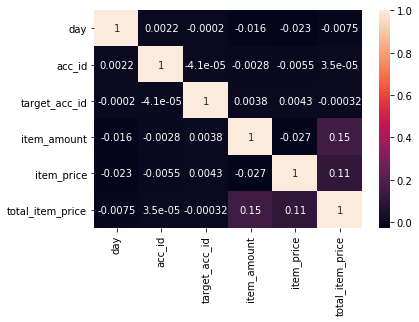

In [943]:
import seaborn as sns
matcorr = trade.corr()
sns.heatmap(matcorr, annot=True)

# item_price와 그나마 가장 관련이 큰 것이 item_type : item_type에 맞춰서 보간

In [944]:
trade['item_price'].isnull().sum()

424697

In [945]:
trade['item_price'].notnull().sum()

409781

### item type에 따른 item_price의 평균값
### adena 주고받은 것은 무조건 nan (교환창 거래)

In [946]:
trade.groupby('item_type')['item_price'].apply(lambda x: x.isnull().sum())

item_type
0     53980
1    122798
2     69453
3     20851
4    113248
5     15551
6     28816
Name: item_price, dtype: int64

In [947]:
trade.groupby('item_type')['item_price'].apply(lambda x: x.notnull().sum())

item_type
0      7592
1         0
2     29679
3     94215
4    263822
5      9647
6      4826
Name: item_price, dtype: int64

In [948]:
trade[(trade['item_price'].isnull() & trade['item_type']==1)]

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin,total_item_price
0,7,1,6,11439,48152,3,4.793968e-08,NaN,21,NaN
6,2,1,21,10578,52677,4,4.793968e-05,NaN,21,NaN
8,6,1,21,107975,13885,4,7.670349e-06,NaN,2,NaN
13,7,1,28,9274,13180,4,2.396984e-08,NaN,17,NaN
25,7,1,23,54845,69413,1,1.198492e-02,NaN,10,NaN
...,...,...,...,...,...,...,...,...,...,...
1849293,22,1,16,117155,33195,1,1.198492e-01,NaN,19,NaN
1849294,26,1,23,108850,2556,1,2.107588e+00,NaN,18,NaN
1849306,24,1,17,7584,70097,2,1.198492e-07,NaN,16,NaN
1849307,22,1,13,29334,83591,6,2.396984e-08,NaN,3,NaN


In [949]:
trade[(trade['item_type']==1)]

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin,total_item_price
25,7,1,23,54845,69413,1,0.011985,NaN,10,NaN
44,2,1,9,25686,16745,1,0.020374,NaN,23,NaN
47,6,1,11,111023,128502,1,0.167789,NaN,7,NaN
48,2,1,28,96753,16116,1,0.026247,NaN,1,NaN
52,7,1,28,120127,38387,1,0.009828,NaN,19,NaN
...,...,...,...,...,...,...,...,...,...,...
1849222,28,1,25,78404,6489,1,22.426198,NaN,17,NaN
1849277,27,1,20,44689,121994,1,0.031400,NaN,0,NaN
1849292,28,1,0,63511,26938,1,0.239698,NaN,0,NaN
1849293,22,1,16,117155,33195,1,0.119849,NaN,19,NaN


## item_type가 1인것과 전체의 sum() 그래프가 비슷하다?? : adena는 item_amount가 가격이네!

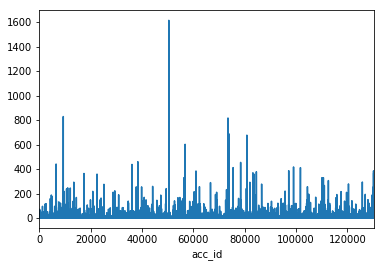

In [950]:
trade[(trade['item_type']==1)].groupby('acc_id')['item_amount'].sum().plot()

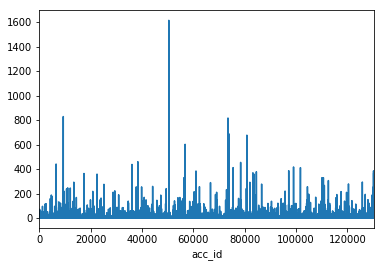

In [951]:
trade.groupby('acc_id')['item_amount'].sum().plot()

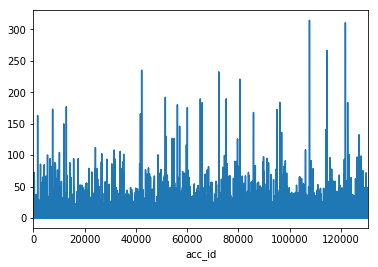

In [952]:
trade.groupby('acc_id')['item_price'].sum().plot()

# item_amount 의 std, mean을 해보자

In [953]:
trade['item_amount'].min()

2.3969839259754707e-08

In [954]:
# 와! 돈이 그대로 나오잖아!
trade_item_amount_rev = trade['item_amount']/2.3969839259754707e-08
trade_item_amount_rev

0             2.0
2             3.0
5             3.0
6          2000.0
8           320.0
            ...  
1849306       5.0
1849307       1.0
1849308      10.0
1849310       1.0
1849315       1.0
Name: item_amount, Length: 834478, dtype: float64

In [955]:
trade_item_amount_rev.isnull().sum()

0

In [956]:
trade_item_amount_rev.max()

3457858551.0

In [957]:
trade['item_price'].min()

9.521860963149264e-08

In [958]:
trade_item_price_rev = trade['item_price']/9.521860963149264e-08
trade_item_price_rev

0              NaN
2              NaN
5          59787.0
6              NaN
8              NaN
            ...   
1849306        NaN
1849307        NaN
1849308        NaN
1849310    29499.0
1849315    19644.0
Name: item_price, Length: 834478, dtype: float64

In [959]:
trade_item_price_rev.max()

690900000.0000001

In [960]:
trade_item_price_rev.min()

1.0

In [961]:
trade_item_price_rev.isnull().sum()

424697

### 일단 요 역정규화 된 값들을 다시 넣어주자!

In [962]:
trade['item_amount'] = trade_item_amount_rev
trade['item_price'] = trade_item_price_rev
trade.head()

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin,total_item_price
0,7,1,6,11439,48152,3,2.0,NaN,21,NaN
2,1,1,11,18212,38145,0,3.0,NaN,14,NaN
5,2,0,9,90975,22407,3,3.0,59787.0,16,4.093690e-10
6,2,1,21,10578,52677,4,2000.0,NaN,21,NaN
8,6,1,21,107975,13885,4,320.0,NaN,2,NaN


In [963]:
# def func(row):
#     if row['item_type'] == 1:
#         return row['item_amount']
#     else:
#         return row['item_price']

In [964]:
# # 이거 쓰는것보다 numpy 배열 쓰는게 훠얼씬 빠를듯!
# trade['item_price'] = trade.apply(func,axis=1)

In [965]:
trade['item_price'] = np.where(trade['item_type']==1, trade['item_amount'], trade['item_price'])

In [966]:
trade[trade['item_type']==1]

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin,total_item_price
25,7,1,23,54845,69413,1,500000.0,500000.0,10,NaN
44,2,1,9,25686,16745,1,850000.0,850000.0,23,NaN
47,6,1,11,111023,128502,1,7000000.0,7000000.0,7,NaN
48,2,1,28,96753,16116,1,1095000.0,1095000.0,1,NaN
52,7,1,28,120127,38387,1,410000.0,410000.0,19,NaN
...,...,...,...,...,...,...,...,...,...,...
1849222,28,1,25,78404,6489,1,935600674.0,935600674.0,17,NaN
1849277,27,1,20,44689,121994,1,1310000.0,1310000.0,0,NaN
1849292,28,1,0,63511,26938,1,10000000.0,10000000.0,0,NaN
1849293,22,1,16,117155,33195,1,5000000.0,5000000.0,19,NaN


In [967]:
trade['item_amount'] = np.where(trade['item_type']==1, 1, trade['item_amount'])

In [968]:
trade[trade['item_type']==1].head()

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin,total_item_price
25,7,1,23,54845,69413,1,1.0,500000.0,10,NaN
44,2,1,9,25686,16745,1,1.0,850000.0,23,NaN
47,6,1,11,111023,128502,1,1.0,7000000.0,7,NaN
48,2,1,28,96753,16116,1,1.0,1095000.0,1,NaN
52,7,1,28,120127,38387,1,1.0,410000.0,19,NaN


In [969]:
trade['item_price'].isnull().sum()

301899

In [970]:
trade.groupby('item_type')['item_price'].mean()

item_type
0    1.439120e+07
1    3.128640e+07
2    6.328192e+06
3    7.828820e+05
4    1.525780e+06
5    1.641845e+06
6    1.151043e+07
Name: item_price, dtype: float64

In [971]:
trade[trade['item_type']==2]

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin,total_item_price
31,1,1,7,98736,52740,2,7.0,NaN,1,NaN
37,7,1,26,71795,82923,2,1.0,NaN,22,NaN
63,6,1,17,50937,12940,2,1.0,NaN,22,NaN
68,7,1,7,5096,50413,2,5.0,NaN,18,NaN
81,3,0,0,54685,3553,2,1.0,350000.0,15,7.988312e-10
...,...,...,...,...,...,...,...,...,...,...
1849157,22,0,4,24698,97278,2,1.0,22239973.0,0,5.075995e-08
1849200,28,1,28,13715,18996,2,2.0,NaN,19,NaN
1849245,27,0,28,34405,29525,2,1.0,26989.0,17,6.159901e-11
1849256,25,1,13,117200,4234,2,1.0,NaN,19,NaN


In [972]:
trade[trade['type']==1]

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin,total_item_price
0,7,1,6,11439,48152,3,2.0,NaN,21,NaN
2,1,1,11,18212,38145,0,3.0,NaN,14,NaN
6,2,1,21,10578,52677,4,2000.0,NaN,21,NaN
8,6,1,21,107975,13885,4,320.0,NaN,2,NaN
13,7,1,28,9274,13180,4,1.0,NaN,17,NaN
...,...,...,...,...,...,...,...,...,...,...
1849293,22,1,16,117155,33195,1,1.0,5000000.0,19,NaN
1849294,26,1,23,108850,2556,1,1.0,87926669.0,18,NaN
1849306,24,1,17,7584,70097,2,5.0,NaN,16,NaN
1849307,22,1,13,29334,83591,6,1.0,NaN,3,NaN


In [973]:
trade[trade['type']==0]

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin,total_item_price
5,2,0,9,90975,22407,3,3.0,59787.0,16,4.093690e-10
16,2,0,25,66690,113748,4,3.0,839850.0,12,5.750557e-09
17,1,0,20,123016,41595,3,1.0,23860.0,19,5.445746e-11
18,5,0,28,90072,114512,4,15.0,449120.0,16,1.537590e-08
19,4,0,24,128472,124440,4,3.0,95931.0,13,6.568515e-10
...,...,...,...,...,...,...,...,...,...,...
1849291,26,0,3,30170,119337,4,3.0,150156.0,13,1.028137e-09
1849303,25,0,24,104024,15878,3,1.0,34807.0,20,7.944262e-11
1849305,27,0,0,28820,40153,3,10.0,300990.0,10,6.869720e-09
1849310,25,0,28,14799,1145,4,1.0,29499.0,4,6.732777e-11


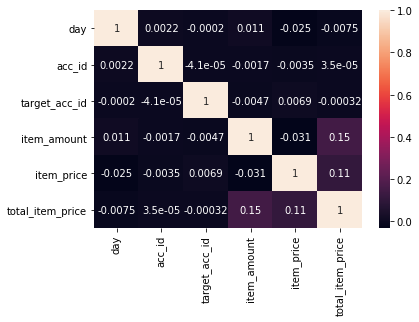

In [974]:
trade_corrmat = trade.corr()
import seaborn as sns
sns.heatmap(trade_corrmat, annot=True)

## 이 위까지 하고 null 값 버리고 해도 됨!

## 그래도 보간은 일단 해주자 : type에 따른 평균으로

In [975]:
trade[trade['type']==1].isnull().sum()

day                      0
type                     0
server                   0
acc_id                   0
target_acc_id            0
item_type                0
item_amount              0
item_price          301899
time_bin                 0
total_item_price    424697
dtype: int64

In [976]:
trade

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin,total_item_price
0,7,1,6,11439,48152,3,2.0,NaN,21,NaN
2,1,1,11,18212,38145,0,3.0,NaN,14,NaN
5,2,0,9,90975,22407,3,3.0,59787.0,16,4.093690e-10
6,2,1,21,10578,52677,4,2000.0,NaN,21,NaN
8,6,1,21,107975,13885,4,320.0,NaN,2,NaN
...,...,...,...,...,...,...,...,...,...,...
1849306,24,1,17,7584,70097,2,5.0,NaN,16,NaN
1849307,22,1,13,29334,83591,6,1.0,NaN,3,NaN
1849308,28,1,28,112005,127249,4,10.0,NaN,21,NaN
1849310,25,0,28,14799,1145,4,1.0,29499.0,4,6.732777e-11


In [977]:
# trade.groupby('item_type')['item_price'].transform(lambda x: x.mean())

In [978]:
trade['item_price'] = trade.groupby('item_type')['item_price'].transform(lambda x: x.fillna(x.mean()))

In [979]:
trade.isnull().sum()

day                      0
type                     0
server                   0
acc_id                   0
target_acc_id            0
item_type                0
item_amount              0
item_price               0
time_bin                 0
total_item_price    424697
dtype: int64

In [980]:
trade["total_item_price"] = trade["item_amount"] * trade["item_price"]
trade.isnull().sum()

day                 0
type                0
server              0
acc_id              0
target_acc_id       0
item_type           0
item_amount         0
item_price          0
time_bin            0
total_item_price    0
dtype: int64

In [981]:
trade.head()

,day,type,server,acc_id,target_acc_id,item_type,item_amount,item_price,time_bin,total_item_price
0,7,1,6,11439,48152,3,2.0,7.828820e+05,21,1.565764e+06
2,1,1,11,18212,38145,0,3.0,1.439120e+07,14,4.317360e+07
5,2,0,9,90975,22407,3,3.0,5.978700e+04,16,1.793610e+05
6,2,1,21,10578,52677,4,2000.0,1.525780e+06,21,3.051560e+09
8,6,1,21,107975,13885,4,320.0,1.525780e+06,2,4.882496e+08


In [982]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 834478 entries, 0 to 1849315
Data columns (total 10 columns):
day                 834478 non-null int64
type                834478 non-null category
server              834478 non-null category
acc_id              834478 non-null int64
target_acc_id       834478 non-null int64
item_type           834478 non-null category
item_amount         834478 non-null float64
item_price          834478 non-null float64
time_bin            834478 non-null category
total_item_price    834478 non-null float64
dtypes: category(4), float64(3), int64(3)
memory usage: 47.8 MB


In [983]:
# trade[((trade['item_type']==1)&(trade['acc_id']==54845)&(trade['target_acc_id']==69413))]

In [984]:
# trade[((trade['item_type']==1)&(trade['acc_id']==69413)&(trade['target_acc_id']==54845))]

In [985]:
# trade[((trade['acc_id']==54845)&(trade['target_acc_id']==69413))]

In [986]:
le.classes_

array(['accessory', 'adena', 'armor', 'enchant_scroll', 'etc', 'spell',
       'weapon'], dtype=object)

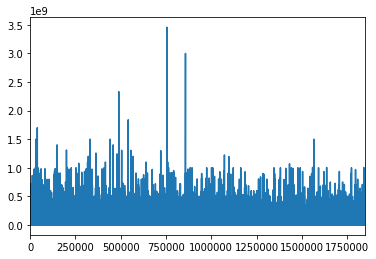

In [987]:
trade['item_price'].plot()

In [988]:
trade['item_price'].max()

3457858551.0

## 파는 캐릭터 : 마이너스(-) 처리 : sell_accesory_amount / sell_adena_amount/sell_armor_amount ... /sell_weapon_amount
## 사는 캐릭터 : 플러스(+) 처리 : get
## 거래숫자 : count / 거래한 가격 : amount

In [1108]:
# Make two trade DataFrames for each source and target
source_trade = trade.drop("target_acc_id", axis=1)
target_trade = trade.drop("acc_id", axis=1)
target_trade.rename(columns={"target_acc_id" : "acc_id"}, inplace=True)

In [1109]:
print(source_trade.shape, target_trade.shape)

(834478, 9) (834478, 9)


In [1110]:
source_trade.head()
# source id의 거래내역

,day,type,server,acc_id,item_type,item_amount,item_price,time_bin,total_item_price
0,7,1,6,11439,3,2.0,7.828820e+05,21,1.565764e+06
2,1,1,11,18212,0,3.0,1.439120e+07,14,4.317360e+07
5,2,0,9,90975,3,3.0,5.978700e+04,16,1.793610e+05
6,2,1,21,10578,4,2000.0,1.525780e+06,21,3.051560e+09
8,6,1,21,107975,4,320.0,1.525780e+06,2,4.882496e+08


In [1111]:
itemtype_list = ['accessory', 'adena', 'armor', 'enchant_scroll', 'etc', 'spell','weapon']
for type in itemtype_list:
    source_trade['sell_amount_'+type] = 0
    source_trade['sell_count_'+type] = 0

In [1112]:
source_trade.head()

,day,type,server,acc_id,item_type,item_amount,item_price,time_bin,total_item_price,sell_amount_accessory,sell_count_accessory,sell_amount_adena,sell_count_adena,sell_amount_armor,sell_count_armor,sell_amount_enchant_scroll,sell_count_enchant_scroll,sell_amount_etc,sell_count_etc,sell_amount_spell,sell_count_spell,sell_amount_weapon,sell_count_weapon
0,7,1,6,11439,3,2.0,7.828820e+05,21,1.565764e+06,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,11,18212,0,3.0,1.439120e+07,14,4.317360e+07,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,0,9,90975,3,3.0,5.978700e+04,16,1.793610e+05,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2,1,21,10578,4,2000.0,1.525780e+06,21,3.051560e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,6,1,21,107975,4,320.0,1.525780e+06,2,4.882496e+08,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1113]:
source_trade.columns

Index(['day', 'type', 'server', 'acc_id', 'item_type', 'item_amount',
       'item_price', 'time_bin', 'total_item_price', 'sell_amount_accessory',
       'sell_count_accessory', 'sell_amount_adena', 'sell_count_adena',
       'sell_amount_armor', 'sell_count_armor', 'sell_amount_enchant_scroll',
       'sell_count_enchant_scroll', 'sell_amount_etc', 'sell_count_etc',
       'sell_amount_spell', 'sell_count_spell', 'sell_amount_weapon',
       'sell_count_weapon'],
      dtype='object')

In [1114]:
source_trade['item_type'].unique()

[3, 0, 4, 1, 6, 2, 5]
Categories (7, int64): [3, 0, 4, 1, 6, 2, 5]

In [1115]:
source_list = ['sell_count_accessory', 'sell_count_adena', 'sell_count_armor', 'sell_count_enchant_scroll',\
       'sell_count_etc', 'sell_count_spell', 'sell_count_weapon']
source_dict = {x:i for x,i in zip(source_list,range(0,7))}
for source in source_list:
    source_trade[source] = np.where(source_trade['item_type']==source_dict[source], source_trade[source]+source_trade['item_amount'],source_trade[source])

In [1116]:
source_list = ['sell_amount_accessory', 'sell_amount_adena', 'sell_amount_armor', 'sell_amount_enchant_scroll',\
       'sell_amount_etc', 'sell_amount_spell', 'sell_amount_weapon']
source_dict = {x:i for x,i in zip(source_list,range(0,7))}
for source in source_list:
    source_trade[source] = np.where(source_trade['item_type']==source_dict[source], source_trade[source]+(source_trade['total_item_price']),source_trade[source])

In [1117]:
# 어떤 물품을 몇개 거래했는지까지 추가 완료
source_trade = source_trade.rename(columns={"server":"sell_server", "type":"sell_type","total_item_price":"total_sell_item_price","item_amount":"sell_item_amount"\
                                           ,"item_type":"sell_item_type", "item_price":"sell_item_price","time_bin":"sell_time_bin"})
source_trade.head()

,day,sell_type,sell_server,acc_id,sell_item_type,sell_item_amount,sell_item_price,sell_time_bin,total_sell_item_price,sell_amount_accessory,sell_count_accessory,sell_amount_adena,sell_count_adena,sell_amount_armor,sell_count_armor,sell_amount_enchant_scroll,sell_count_enchant_scroll,sell_amount_etc,sell_count_etc,sell_amount_spell,sell_count_spell,sell_amount_weapon,sell_count_weapon
0,7,1,6,11439,3,2.0,7.828820e+05,21,1.565764e+06,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.565764e+06,2.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2,1,1,11,18212,0,3.0,1.439120e+07,14,4.317360e+07,4.317360e+07,3.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
5,2,0,9,90975,3,3.0,5.978700e+04,16,1.793610e+05,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.793610e+05,3.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
6,2,1,21,10578,4,2000.0,1.525780e+06,21,3.051560e+09,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,3.051560e+09,2000.0,0.0,0.0,0.0,0.0
8,6,1,21,107975,4,320.0,1.525780e+06,2,4.882496e+08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,4.882496e+08,320.0,0.0,0.0,0.0,0.0


In [1118]:
target_trade.head()
# target id의 거래내역

,day,type,server,acc_id,item_type,item_amount,item_price,time_bin,total_item_price
0,7,1,6,48152,3,2.0,7.828820e+05,21,1.565764e+06
2,1,1,11,38145,0,3.0,1.439120e+07,14,4.317360e+07
5,2,0,9,22407,3,3.0,5.978700e+04,16,1.793610e+05
6,2,1,21,52677,4,2000.0,1.525780e+06,21,3.051560e+09
8,6,1,21,13885,4,320.0,1.525780e+06,2,4.882496e+08


In [1119]:
itemtype_list = ['accessory', 'adena', 'armor', 'enchant_scroll', 'etc', 'spell','weapon']
for type in itemtype_list:
    target_trade['get_amount_'+type] = 0
    target_trade['get_count_'+type] = 0

In [1120]:
target_trade.columns

Index(['day', 'type', 'server', 'acc_id', 'item_type', 'item_amount',
       'item_price', 'time_bin', 'total_item_price', 'get_amount_accessory',
       'get_count_accessory', 'get_amount_adena', 'get_count_adena',
       'get_amount_armor', 'get_count_armor', 'get_amount_enchant_scroll',
       'get_count_enchant_scroll', 'get_amount_etc', 'get_count_etc',
       'get_amount_spell', 'get_count_spell', 'get_amount_weapon',
       'get_count_weapon'],
      dtype='object')

In [1121]:
target_list = ['get_count_accessory', 'get_count_adena', 'get_count_armor', 'get_count_enchant_scroll',\
       'get_count_etc', 'get_count_spell', 'get_count_weapon']
target_dict = {x:i for x,i in zip(target_list,range(0,7))}
for target in target_list:
    target_trade[target] = np.where(target_trade['item_type']==target_dict[target], target_trade[target]+target_trade['item_amount'],target_trade[target])

In [1122]:
target_list = ['get_amount_accessory', 'get_amount_adena', 'get_amount_armor', 'get_amount_enchant_scroll',\
       'get_amount_etc', 'get_amount_spell', 'get_amount_weapon']
target_dict = {x:i for x,i in zip(target_list,range(0,7))}
for target in target_list:
    target_trade[target] = np.where(target_trade['item_type']==target_dict[target], target_trade[target]+target_trade['total_item_price'],target_trade[target])

In [1123]:
# 어떤 물품을 몇개 거래했는지까지 추가 완료
target_trade = target_trade.rename(columns={"type":"get_type","server":"get_server","total_item_price":"total_get_item_price",'item_amount':'get_item_amount'\
                                           ,"item_type":"get_item_type",'item_price':"get_item_price","time_bin":"get_time_bin"})
target_trade.head()

,day,get_type,get_server,acc_id,get_item_type,get_item_amount,get_item_price,get_time_bin,total_get_item_price,get_amount_accessory,get_count_accessory,get_amount_adena,get_count_adena,get_amount_armor,get_count_armor,get_amount_enchant_scroll,get_count_enchant_scroll,get_amount_etc,get_count_etc,get_amount_spell,get_count_spell,get_amount_weapon,get_count_weapon
0,7,1,6,48152,3,2.0,7.828820e+05,21,1.565764e+06,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.565764e+06,2.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2,1,1,11,38145,0,3.0,1.439120e+07,14,4.317360e+07,4.317360e+07,3.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
5,2,0,9,22407,3,3.0,5.978700e+04,16,1.793610e+05,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.793610e+05,3.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
6,2,1,21,52677,4,2000.0,1.525780e+06,21,3.051560e+09,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,3.051560e+09,2000.0,0.0,0.0,0.0,0.0
8,6,1,21,13885,4,320.0,1.525780e+06,2,4.882496e+08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,4.882496e+08,320.0,0.0,0.0,0.0,0.0


In [1124]:
# Total number of trade occurence per account the whole period

source_trade_count = source_trade["acc_id"].value_counts()
target_trade_count = target_trade["acc_id"].value_counts()

In [1125]:
source_trade_count.head()

50413     3530
116315    2600
52260     2500
68330     2346
92665     2335
Name: acc_id, dtype: int64

In [1126]:
target_trade_count.head()

50413     3502
120428    2909
91062     2685
111023    1983
62350     1980
Name: acc_id, dtype: int64

In [1127]:
source_trade_count = pd.DataFrame({"acc_id" : source_trade_count.index,
                                   "count" : source_trade_count})    # Make a dataframe to merge based on "acc_id"
target_trade_count = pd.DataFrame({"acc_id" : target_trade_count.index,
                                   "count" : target_trade_count})

In [1128]:
source_trade_count.head()

,acc_id,count
50413,50413,3530
116315,116315,2600
52260,52260,2500
68330,68330,2346
92665,92665,2335


In [1129]:
target_trade_count.head()

,acc_id,count
50413,50413,3502
120428,120428,2909
91062,91062,2685
111023,111023,1983
62350,62350,1980


In [1130]:
print(source_trade_count.shape, target_trade_count.shape)

(24630, 2) (28890, 2)


In [1131]:
train_combat['acc_id'].value_counts().size

40000

In [1132]:
train_combat['acc_id'].unique()

array([13809, 62835, 54241, ..., 70769, 49584, 66902], dtype=int64)

In [1133]:
acc_id = pd.DataFrame(train_combat['acc_id'].unique(),columns=['acc_id'])
source_trade_count = pd.merge(source_trade_count, acc_id, on="acc_id", how='inner')
target_trade_count = pd.merge(target_trade_count, acc_id, on="acc_id", how='inner')

In [1134]:
print(source_trade_count.shape, target_trade_count.shape)

(24630, 2) (28890, 2)


In [1135]:
source_trade_count.head()

,acc_id,count
0,50413,3530
1,116315,2600
2,52260,2500
3,68330,2346
4,92665,2335


In [1243]:
trade_count = pd.merge(source_trade_count, target_trade_count, on = "acc_id", how='outer')
trade_count = trade_count.fillna(0)
trade_count["count"] = trade_count["count_x"] + trade_count["count_y"]
trade_count.head()

,acc_id,count_x,count_y,count
0,50413,3530.0,3502.0,7032.0
1,116315,2600.0,195.0,2795.0
2,52260,2500.0,193.0,2693.0
3,68330,2346.0,196.0,2542.0
4,92665,2335.0,200.0,2535.0


In [1244]:
trade_count.tail()

,acc_id,count_x,count_y,count
32010,48491,0.0,1.0,1.0
32011,91786,0.0,1.0,1.0
32012,83284,0.0,1.0,1.0
32013,23212,0.0,1.0,1.0
32014,7039,0.0,1.0,1.0


In [1137]:
trade_count.shape

(32015, 4)

In [1282]:
# trade_count.drop(["count_x", "count_y"], axis=1, inplace=True)
trade_count = trade_count.rename(columns={'count':'total_trade_count', 'count_x':'count_sell', 'count_y':'count_get'})
trade_count.head()

,acc_id,count_sell,count_get,total_trade_count
0,50413,3530.0,3502.0,7032.0
1,116315,2600.0,195.0,2795.0
2,52260,2500.0,193.0,2693.0
3,68330,2346.0,196.0,2542.0
4,92665,2335.0,200.0,2535.0


In [1283]:
trade_count = trade_count.astype('int')

In [1284]:
trade_count.shape

(32015, 4)

In [1141]:
# 현재 이건 오직 source acc_id data만 있는 것!
# source_trade = trade.drop(["target_acc_id", "item_type", "item_amount", "item_price"], axis=1)
# target_trade = trade.drop(["acc_id", "item_type", "item_amount", "item_price"], axis=1)
source_trade.head()

,day,sell_type,sell_server,acc_id,sell_item_type,sell_item_amount,sell_item_price,sell_time_bin,total_sell_item_price,sell_amount_accessory,sell_count_accessory,sell_amount_adena,sell_count_adena,sell_amount_armor,sell_count_armor,sell_amount_enchant_scroll,sell_count_enchant_scroll,sell_amount_etc,sell_count_etc,sell_amount_spell,sell_count_spell,sell_amount_weapon,sell_count_weapon
0,7,1,6,11439,3,2.0,7.828820e+05,21,1.565764e+06,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.565764e+06,2.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2,1,1,11,18212,0,3.0,1.439120e+07,14,4.317360e+07,4.317360e+07,3.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
5,2,0,9,90975,3,3.0,5.978700e+04,16,1.793610e+05,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.793610e+05,3.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
6,2,1,21,10578,4,2000.0,1.525780e+06,21,3.051560e+09,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,3.051560e+09,2000.0,0.0,0.0,0.0,0.0
8,6,1,21,107975,4,320.0,1.525780e+06,2,4.882496e+08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,4.882496e+08,320.0,0.0,0.0,0.0,0.0


In [1142]:
source_trade.shape

(834478, 23)

In [1143]:
target_trade.head()

,day,get_type,get_server,acc_id,get_item_type,get_item_amount,get_item_price,get_time_bin,total_get_item_price,get_amount_accessory,get_count_accessory,get_amount_adena,get_count_adena,get_amount_armor,get_count_armor,get_amount_enchant_scroll,get_count_enchant_scroll,get_amount_etc,get_count_etc,get_amount_spell,get_count_spell,get_amount_weapon,get_count_weapon
0,7,1,6,48152,3,2.0,7.828820e+05,21,1.565764e+06,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.565764e+06,2.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2,1,1,11,38145,0,3.0,1.439120e+07,14,4.317360e+07,4.317360e+07,3.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
5,2,0,9,22407,3,3.0,5.978700e+04,16,1.793610e+05,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.793610e+05,3.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
6,2,1,21,52677,4,2000.0,1.525780e+06,21,3.051560e+09,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,3.051560e+09,2000.0,0.0,0.0,0.0,0.0
8,6,1,21,13885,4,320.0,1.525780e+06,2,4.882496e+08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,4.882496e+08,320.0,0.0,0.0,0.0,0.0


In [1144]:
target_trade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 834478 entries, 0 to 1849315
Data columns (total 23 columns):
day                          834478 non-null int64
get_type                     834478 non-null category
get_server                   834478 non-null category
acc_id                       834478 non-null int64
get_item_type                834478 non-null category
get_item_amount              834478 non-null float64
get_item_price               834478 non-null float64
get_time_bin                 834478 non-null category
total_get_item_price         834478 non-null float64
get_amount_accessory         834478 non-null float64
get_count_accessory          834478 non-null float64
get_amount_adena             834478 non-null float64
get_count_adena              834478 non-null float64
get_amount_armor             834478 non-null float64
get_count_armor              834478 non-null float64
get_amount_enchant_scroll    834478 non-null float64
get_count_enchant_scroll     834478 non-

In [1145]:
target_trade['get_time_bin'].values.max

<bound method Categorical.max of [21, 14, 16, 21, 2, ..., 16, 3, 21, 4, 11]
Length: 834478
Categories (24, int64): [0 < 1 < 2 < 3 ... 20 < 21 < 22 < 23]>

In [1146]:
pd.get_dummies(target_trade)

,day,acc_id,get_item_amount,get_item_price,total_get_item_price,get_amount_accessory,get_count_accessory,get_amount_adena,get_count_adena,get_amount_armor,get_count_armor,get_amount_enchant_scroll,get_count_enchant_scroll,get_amount_etc,get_count_etc,get_amount_spell,get_count_spell,get_amount_weapon,get_count_weapon,get_type_0,get_type_1,get_server_0,get_server_1,get_server_2,get_server_3,get_server_4,get_server_5,get_server_6,get_server_7,get_server_8,get_server_9,get_server_10,get_server_11,get_server_12,get_server_13,get_server_14,get_server_15,get_server_16,get_server_17,get_server_18,get_server_19,get_server_20,get_server_21,get_server_22,get_server_23,get_server_24,get_server_25,get_server_26,get_server_27,get_server_28,get_server_29,get_server_39,get_item_type_0,get_item_type_1,get_item_type_2,get_item_type_3,get_item_type_4,get_item_type_5,get_item_type_6,get_time_bin_0,get_time_bin_1,get_time_bin_2,get_time_bin_3,get_time_bin_4,get_time_bin_5,get_time_bin_6,get_time_bin_7,get_time_bin_8,get_time_bin_9,get_time_bin_10,get_time_bin_11,get_time_bin_12,get_time_bin_13,get_time_bin_14,get_time_bin_15,get_time_bin_16,get_time_bin_17,get_time_bin_18,get_time_bin_19,get_time_bin_20,get_time_bin_21,get_time_bin_22,get_time_bin_23
0,7,48152,2.0,7.828820e+05,1.565764e+06,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,1.565764e+06,2.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,38145,3.0,1.439120e+07,4.317360e+07,4.317360e+07,3.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,2,22407,3.0,5.978700e+04,1.793610e+05,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,1.793610e+05,3.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,2,52677,2000.0,1.525780e+06,3.051560e+09,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,3.051560e+09,2000.0,0.0,0.0,0.000000e+00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,6,13885,320.0,1.525780e+06,4.882496e+08,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,4.882496e+08,320.0,0.0,0.0,0.000000e+00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849306,24,70097,5.0,6.328192e+06,3.164096e+07,0.000000e+00,0.0,0.0,0.0,3.164096e+07,5.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1849307,22,83591,1.0,1.151043e+07,1.151043e+07,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,1.151043e+07,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1849308,28,127249,10.0,1.525780e+06,1.525780e+07,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,1.525780e+07,10.0,0.0,0.0,0.000000e+00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1849310,25,1145,1.0,2.949900e+04,2.949900e+04,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,2.949900e+04,1.0,0.0,0.0,0.000000e+00,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,

In [1147]:
pd.get_dummies(source_trade)

,day,acc_id,sell_item_amount,sell_item_price,total_sell_item_price,sell_amount_accessory,sell_count_accessory,sell_amount_adena,sell_count_adena,sell_amount_armor,sell_count_armor,sell_amount_enchant_scroll,sell_count_enchant_scroll,sell_amount_etc,sell_count_etc,sell_amount_spell,sell_count_spell,sell_amount_weapon,sell_count_weapon,sell_type_0,sell_type_1,sell_server_0,sell_server_1,sell_server_2,sell_server_3,sell_server_4,sell_server_5,sell_server_6,sell_server_7,sell_server_8,sell_server_9,sell_server_10,sell_server_11,sell_server_12,sell_server_13,sell_server_14,sell_server_15,sell_server_16,sell_server_17,sell_server_18,sell_server_19,sell_server_20,sell_server_21,sell_server_22,sell_server_23,sell_server_24,sell_server_25,sell_server_26,sell_server_27,sell_server_28,sell_server_29,sell_server_39,sell_item_type_0,sell_item_type_1,sell_item_type_2,sell_item_type_3,sell_item_type_4,sell_item_type_5,sell_item_type_6,sell_time_bin_0,sell_time_bin_1,sell_time_bin_2,sell_time_bin_3,sell_time_bin_4,sell_time_bin_5,sell_time_bin_6,sell_time_bin_7,sell_time_bin_8,sell_time_bin_9,sell_time_bin_10,sell_time_bin_11,sell_time_bin_12,sell_time_bin_13,sell_time_bin_14,sell_time_bin_15,sell_time_bin_16,sell_time_bin_17,sell_time_bin_18,sell_time_bin_19,sell_time_bin_20,sell_time_bin_21,sell_time_bin_22,sell_time_bin_23
0,7,11439,2.0,7.828820e+05,1.565764e+06,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,1.565764e+06,2.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,18212,3.0,1.439120e+07,4.317360e+07,4.317360e+07,3.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,2,90975,3.0,5.978700e+04,1.793610e+05,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,1.793610e+05,3.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,2,10578,2000.0,1.525780e+06,3.051560e+09,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,3.051560e+09,2000.0,0.0,0.0,0.000000e+00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,6,107975,320.0,1.525780e+06,4.882496e+08,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,4.882496e+08,320.0,0.0,0.0,0.000000e+00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849306,24,7584,5.0,6.328192e+06,3.164096e+07,0.000000e+00,0.0,0.0,0.0,3.164096e+07,5.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1849307,22,29334,1.0,1.151043e+07,1.151043e+07,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,1.151043e+07,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1849308,28,112005,10.0,1.525780e+06,1.525780e+07,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,1.525780e+07,10.0,0.0,0.0,0.000000e+00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1849310,25,14799,1.0,2.949900e+04,2.949900e+04,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,2.949900e+04,1.0,0.0,0.0,0.000000e+00,0.

In [1148]:
target_trade_sparse = pd.get_dummies(target_trade)
source_trade_sparse = pd.get_dummies(source_trade)

In [1149]:
# pd.merge(source_trade,acc_id,on='acc_id',how='inner').isnull().sum()

In [1150]:
pd.pivot_table(data=source_trade_sparse, index=["acc_id", "day"],aggfunc=sum)

sell_amount_accessory  sell_amount_adena  sell_amount_armor  \
acc_id day                                                                
2      1                      0.0                0.0                0.0   
       2                      0.0         13000000.0                0.0   
       3                      0.0                0.0                0.0   
       5                      0.0                0.0           798000.0   
       7                      0.0                0.0                0.0   
...                           ...                ...                ...   
130470 28                     0.0          3000000.0                0.0   
130473 20                     0.0             1000.0                0.0   
       21                     0.0         50000000.0                0.0   
       22                     0.0        100000000.0                0.0   
       23                     0.0        100000000.0                0.0   

            sell_amount_enchant_scroll  sell_amount_etc  sell_amount_spell  \
acc_id day                                                                   
2      1                           0.0      745829898.0                0.0   
       2                           0.0              0.0                0.0   
       3                           0.0      498780142.0                0.0   
       5                           0.0              0.0                0.0   
       7                           0.0      628290000.0                0.0   
...                                ...              ...                ...   
130470 28                          0.0              0.0                0.0   
130473 20                          0.0              0.0                0.0   
       21                          0.0              0.0                0.0   
       22                          0.0              0.0                0.0   
       23                          0.0              0.0                0.0   

            sell_amount_weapon  sell_count_accessory  sell_count_adena  \
acc_id day                                                               
2      1                   0.0                   0.0               0.0   
       2                   0.0                   0.0               1.0   
       3                   0.0                   0.0               0.0   
       5                   0.0                   0.0               0.0   
       7                   0.0                   0.0               0.0   
...                        ...                   ...               ...   
130470 28                  0.0                   0.0               1.0   
130473 20                  0.0                   0.0               1.0   
       21                  0.0                   0.0               1.0   
       22                  0.0                   0.0               1.0   
       23                  0.0                   0.0               1.0   

            sell_count_armor  sell_count_enchant_scroll  sell_count_etc  \
acc_id day                                                                
2      1                 0.0                        0.0            66.0   
       2                 0.0                        0.0             0.0   
       3                 0.0                        0.0            31.0   
       5                 1.0                        0.0             0.0   
       7                 0.0                        0.0            50.0   
...                      ...                        ...             ...   
130470 28                0.0                        0.0             0.0   
130473 20                0.0                        0.0             0.0   
       21                0.0                        0.0             0.0   
       22                0.0                        0.0             0.0   
       23                0.0                        0.0             0.0   

            sell_count_spell  sell_count_weapon  sell_item_amount  \
acc_id day   

In [1252]:
source_pivot = pd.pivot_table(data=source_trade_sparse, index=["acc_id", "day"],aggfunc=sum)

In [1253]:
source_pivot.head()

sell_amount_accessory  sell_amount_adena  sell_amount_armor  \
acc_id day                                                                
2      1                      0.0                0.0                0.0   
       2                      0.0         13000000.0                0.0   
       3                      0.0                0.0                0.0   
       5                      0.0                0.0           798000.0   
       7                      0.0                0.0                0.0   

            sell_amount_enchant_scroll  sell_amount_etc  sell_amount_spell  \
acc_id day                                                                   
2      1                           0.0      745829898.0                0.0   
       2                           0.0              0.0                0.0   
       3                           0.0      498780142.0                0.0   
       5                           0.0              0.0                0.0   
       7                           0.0      628290000.0                0.0   

            sell_amount_weapon  sell_count_accessory  sell_count_adena  \
acc_id day                                                               
2      1                   0.0                   0.0               0.0   
       2                   0.0                   0.0               1.0   
       3                   0.0                   0.0               0.0   
       5                   0.0                   0.0               0.0   
       7                   0.0                   0.0               0.0   

            sell_count_armor  sell_count_enchant_scroll  sell_count_etc  \
acc_id day                                                                
2      1                 0.0                        0.0            66.0   
       2                 0.0                        0.0             0.0   
       3                 0.0                        0.0            31.0   
       5                 1.0                        0.0             0.0   
       7                 0.0                        0.0            50.0   

            sell_count_spell  sell_count_weapon  sell_item_amount  \
acc_id day                                                          
2      1                 0.0                0.0              66.0   
       2                 0.0                0.0               1.0   
       3                 0.0                0.0              31.0   
       5                 0.0                0.0               1.0   
       7                 0.0                0.0              50.0   

            sell_item_price  sell_item_type_0  sell_item_type_1  \
acc_id day                                                        
2      1         18063768.0                 0                 0   
       2         13000000.0                 0                 1   
       3         16089682.0                 0                 0   
       5           798000.0                 0                 0   
       7         12565800.0                 0                 0   

            sell_item_type_2  sell_item_type_3  sell_item_type_4  \
acc_id day                                                         
2      1                   0                 0                 3   
       2                   0                 0                 0   
       3                   0                 0                 1   
       5                   1                 0                 0   
       7                   0                 0                 1   

            sell_item_type_5  sell_item_type_6  sell_server_0  sell_server_1  \
acc_id day                                                                     
2      1                   0                 0              0              0   
       2                   0                 0              0              0   
       3                   0                 0              0              0   
       5                   0                 0              0  

In [1254]:
pd.pivot_table(data=target_trade_sparse, index=["acc_id", "day"],aggfunc=sum)

get_amount_accessory  get_amount_adena  get_amount_armor  \
acc_id day                                                             
2      9                     0.0               0.0               0.0   
5      20                    0.0               0.0               0.0   
       22                    0.0               0.0               0.0   
       23                    0.0               0.0               0.0   
       25                    0.0               0.0               0.0   
...                          ...               ...               ...   
130470 27                    0.0               0.0               0.0   
       28                    0.0               0.0               0.0   
130473 5                     0.0         4000000.0               0.0   
       18                    0.0               0.0               0.0   
       19                    0.0         2000000.0               0.0   

            get_amount_enchant_scroll  get_amount_etc  get_amount_spell  \
acc_id day                                                                
2      9                          0.0        285902.0               0.0   
5      20                         0.0      21500000.0               0.0   
       22                         0.0     264000000.0               0.0   
       23                         0.0      88000000.0               0.0   
       25                         0.0     170491288.0               0.0   
...                               ...             ...               ...   
130470 27                    474755.0        799600.0               0.0   
       28                    662759.0       5000000.0               0.0   
130473 5                          0.0             0.0               0.0   
       18                  10531000.0             0.0               0.0   
       19                         0.0             0.0               0.0   

            get_amount_weapon  get_count_accessory  get_count_adena  \
acc_id day                                                            
2      9                  0.0                  0.0              0.0   
5      20                 0.0                  0.0              0.0   
       22                 0.0                  0.0              0.0   
       23                 0.0                  0.0              0.0   
       25                 0.0                  0.0              0.0   
...                       ...                  ...              ...   
130470 27                 0.0                  0.0              0.0   
       28                 0.0                  0.0              0.0   
130473 5                  0.0                  0.0              1.0   
       18                 0.0                  0.0              0.0   
       19                 0.0                  0.0              1.0   

            get_count_armor  get_count_enchant_scroll  get_count_etc  \
acc_id day                                                             
2      9                0.0                       0.0            2.0   
5      20               0.0                       0.0          500.0   
       22               0.0                       0.0         3000.0   
       23               0.0                       0.0         1000.0   
       25               0.0                       0.0         1799.0   
...                     ...                       ...            ...   
130470 27               0.0                       1.0           20.0   
       28               0.0                       2.0           50.0   
130473 5                0.0                       0.0            0.0   
       18               0.0                       1.0            0.0   
       19               0.0                       0.0            0.0   

            get_count_spell  get_count_weapon  get_item_amount  \
acc_id day                                                       
2      9                0.0               0.0              2.0   
5      20               0.0             

In [1255]:
target_pivot = pd.pivot_table(data=target_trade_sparse, index=["acc_id", "day"],aggfunc=sum)

In [1256]:
target_pivot.head()

get_amount_accessory  get_amount_adena  get_amount_armor  \
acc_id day                                                             
2      9                     0.0               0.0               0.0   
5      20                    0.0               0.0               0.0   
       22                    0.0               0.0               0.0   
       23                    0.0               0.0               0.0   
       25                    0.0               0.0               0.0   

            get_amount_enchant_scroll  get_amount_etc  get_amount_spell  \
acc_id day                                                                
2      9                          0.0        285902.0               0.0   
5      20                         0.0      21500000.0               0.0   
       22                         0.0     264000000.0               0.0   
       23                         0.0      88000000.0               0.0   
       25                         0.0     170491288.0               0.0   

            get_amount_weapon  get_count_accessory  get_count_adena  \
acc_id day                                                            
2      9                  0.0                  0.0              0.0   
5      20                 0.0                  0.0              0.0   
       22                 0.0                  0.0              0.0   
       23                 0.0                  0.0              0.0   
       25                 0.0                  0.0              0.0   

            get_count_armor  get_count_enchant_scroll  get_count_etc  \
acc_id day                                                             
2      9                0.0                       0.0            2.0   
5      20               0.0                       0.0          500.0   
       22               0.0                       0.0         3000.0   
       23               0.0                       0.0         1000.0   
       25               0.0                       0.0         1799.0   

            get_count_spell  get_count_weapon  get_item_amount  \
acc_id day                                                       
2      9                0.0               0.0              2.0   
5      20               0.0               0.0            500.0   
       22               0.0               0.0           3000.0   
       23               0.0               0.0           1000.0   
       25               0.0               0.0           1799.0   

            get_item_price  get_item_type_0  get_item_type_1  get_item_type_2  \
acc_id day                                                                      
2      9          142951.0                0                0                0   
5      20          43000.0                0                0                0   
       22         264000.0                0                0                0   
       23          88000.0                0                0                0   
       25         158312.0                0                0                0   

            get_item_type_3  get_item_type_4  get_item_type_5  \
acc_id day                                                      
2      9                  0                1                0   
5      20                 0                1                0   
       22                 0                3                0   
       23                 0                1                0   
       25                 0                2                0   

            get_item_type_6  get_server_0  get_server_1  get_server_10  \
acc_id day                                                               
2      9                  0             0             0              0   
5      20                 0             0             0              0   
       22                 0             0             0              0   
       23                 0             0             0              0   
       25                 0             0      

In [1257]:
merged_trade = pd.merge(source_pivot, target_pivot, on=['acc_id','day'], how='outer') # fillna는 잠시만 있다가

In [1258]:
merged_trade

sell_amount_accessory  sell_amount_adena  sell_amount_armor  \
acc_id day                                                                
2      1                      0.0                0.0                0.0   
       2                      0.0         13000000.0                0.0   
       3                      0.0                0.0                0.0   
       5                      0.0                0.0           798000.0   
       7                      0.0                0.0                0.0   
...                           ...                ...                ...   
130470 25                     NaN                NaN                NaN   
       27                     NaN                NaN                NaN   
130473 5                      NaN                NaN                NaN   
       18                     NaN                NaN                NaN   
       19                     NaN                NaN                NaN   

            sell_amount_enchant_scroll  sell_amount_etc  sell_amount_spell  \
acc_id day                                                                   
2      1                           0.0      745829898.0                0.0   
       2                           0.0              0.0                0.0   
       3                           0.0      498780142.0                0.0   
       5                           0.0              0.0                0.0   
       7                           0.0      628290000.0                0.0   
...                                ...              ...                ...   
130470 25                          NaN              NaN                NaN   
       27                          NaN              NaN                NaN   
130473 5                           NaN              NaN                NaN   
       18                          NaN              NaN                NaN   
       19                          NaN              NaN                NaN   

            sell_amount_weapon  sell_count_accessory  sell_count_adena  \
acc_id day                                                               
2      1                   0.0                   0.0               0.0   
       2                   0.0                   0.0               1.0   
       3                   0.0                   0.0               0.0   
       5                   0.0                   0.0               0.0   
       7                   0.0                   0.0               0.0   
...                        ...                   ...               ...   
130470 25                  NaN                   NaN               NaN   
       27                  NaN                   NaN               NaN   
130473 5                   NaN                   NaN               NaN   
       18                  NaN                   NaN               NaN   
       19                  NaN                   NaN               NaN   

            sell_count_armor  sell_count_enchant_scroll  sell_count_etc  \
acc_id day                                                                
2      1                 0.0                        0.0            66.0   
       2                 0.0                        0.0             0.0   
       3                 0.0                        0.0            31.0   
       5                 1.0                        0.0             0.0   
       7                 0.0                        0.0            50.0   
...                      ...                        ...             ...   
130470 25                NaN                        NaN             NaN   
       27                NaN                        NaN             NaN   
130473 5                 NaN                        NaN             NaN   
       18                NaN                        NaN             NaN   
       19                NaN                        NaN             NaN   

            sell_count_spell  sell_count_weapon  sell_item_amount  \
acc_id day   

In [1259]:
merged_trade_both = merged_trade[((merged_trade['sell_amount_accessory'].notnull())&(merged_trade['get_amount_accessory'].notnull()))]
merged_trade_both
# 걍 이제 단위 item_price는 drop하는게 맞을듯?

sell_amount_accessory  sell_amount_adena  sell_amount_armor  \
acc_id day                                                                
17     19                     0.0        100000000.0                0.0   
       24                     0.0         60000000.0                0.0   
20     1                      0.0                0.0                0.0   
       16                     0.0         14300000.0                0.0   
31     5                      0.0          8000000.0                0.0   
...                           ...                ...                ...   
130470 18                     0.0          4000000.0                0.0   
       21                     0.0          5000000.0                0.0   
       24                     0.0          3000000.0                0.0   
       26                     0.0          2000000.0                0.0   
       28                     0.0          3000000.0                0.0   

            sell_amount_enchant_scroll  sell_amount_etc  sell_amount_spell  \
acc_id day                                                                   
17     19                 0.000000e+00     0.000000e+00                0.0   
       24                 0.000000e+00     0.000000e+00                0.0   
20     1                  0.000000e+00     1.525780e+06                0.0   
       16                 0.000000e+00     0.000000e+00                0.0   
31     5                  4.775580e+07     2.578568e+08                0.0   
...                                ...              ...                ...   
130470 18                 0.000000e+00     0.000000e+00                0.0   
       21                 0.000000e+00     0.000000e+00                0.0   
       24                 0.000000e+00     0.000000e+00                0.0   
       26                 0.000000e+00     0.000000e+00                0.0   
       28                 0.000000e+00     0.000000e+00                0.0   

            sell_amount_weapon  sell_count_accessory  sell_count_adena  \
acc_id day                                                               
17     19                  0.0                   0.0               1.0   
       24                  0.0                   0.0               1.0   
20     1                   0.0                   0.0               0.0   
       16                  0.0                   0.0               2.0   
31     5                   0.0                   0.0               1.0   
...                        ...                   ...               ...   
130470 18                  0.0                   0.0               1.0   
       21                  0.0                   0.0               1.0   
       24                  0.0                   0.0               1.0   
       26                  0.0                   0.0               1.0   
       28                  0.0                   0.0               1.0   

            sell_count_armor  sell_count_enchant_scroll  sell_count_etc  \
acc_id day                                                                
17     19                0.0                        0.0             0.0   
       24                0.0                        0.0             0.0   
20     1                 0.0                        0.0             1.0   
       16                0.0                        0.0             0.0   
31     5                 0.0                       61.0           169.0   
...                      ...                        ...             ...   
130470 18                0.0                        0.0             0.0   
       21                0.0                        0.0             0.0   
       24                0.0                        0.0             0.0   
       26                0.0                        0.0             0.0   
       28                0.0                        0.0             0.0   

            sell_count_spell  sell_count_weapon  sell_item_amount  \
acc_id day   

In [1260]:
merged_trade = merged_trade.fillna(0)
merged_trade.isnull().sum()

sell_amount_accessory         0
sell_amount_adena             0
sell_amount_armor             0
sell_amount_enchant_scroll    0
sell_amount_etc               0
                             ..
get_time_bin_8                0
get_time_bin_9                0
get_type_0                    0
get_type_1                    0
total_get_item_price          0
Length: 162, dtype: int64

In [1261]:
merged_trade.columns

Index(['sell_amount_accessory', 'sell_amount_adena', 'sell_amount_armor',
       'sell_amount_enchant_scroll', 'sell_amount_etc', 'sell_amount_spell',
       'sell_amount_weapon', 'sell_count_accessory', 'sell_count_adena',
       'sell_count_armor',
       ...
       'get_time_bin_3', 'get_time_bin_4', 'get_time_bin_5', 'get_time_bin_6',
       'get_time_bin_7', 'get_time_bin_8', 'get_time_bin_9', 'get_type_0',
       'get_type_1', 'total_get_item_price'],
      dtype='object', length=162)

In [1262]:
merged_trade.head()

sell_amount_accessory  sell_amount_adena  sell_amount_armor  \
acc_id day                                                                
2      1                      0.0                0.0                0.0   
       2                      0.0         13000000.0                0.0   
       3                      0.0                0.0                0.0   
       5                      0.0                0.0           798000.0   
       7                      0.0                0.0                0.0   

            sell_amount_enchant_scroll  sell_amount_etc  sell_amount_spell  \
acc_id day                                                                   
2      1                           0.0      745829898.0                0.0   
       2                           0.0              0.0                0.0   
       3                           0.0      498780142.0                0.0   
       5                           0.0              0.0                0.0   
       7                           0.0      628290000.0                0.0   

            sell_amount_weapon  sell_count_accessory  sell_count_adena  \
acc_id day                                                               
2      1                   0.0                   0.0               0.0   
       2                   0.0                   0.0               1.0   
       3                   0.0                   0.0               0.0   
       5                   0.0                   0.0               0.0   
       7                   0.0                   0.0               0.0   

            sell_count_armor  sell_count_enchant_scroll  sell_count_etc  \
acc_id day                                                                
2      1                 0.0                        0.0            66.0   
       2                 0.0                        0.0             0.0   
       3                 0.0                        0.0            31.0   
       5                 1.0                        0.0             0.0   
       7                 0.0                        0.0            50.0   

            sell_count_spell  sell_count_weapon  sell_item_amount  \
acc_id day                                                          
2      1                 0.0                0.0              66.0   
       2                 0.0                0.0               1.0   
       3                 0.0                0.0              31.0   
       5                 0.0                0.0               1.0   
       7                 0.0                0.0              50.0   

            sell_item_price  sell_item_type_0  sell_item_type_1  \
acc_id day                                                        
2      1         18063768.0               0.0               0.0   
       2         13000000.0               0.0               1.0   
       3         16089682.0               0.0               0.0   
       5           798000.0               0.0               0.0   
       7         12565800.0               0.0               0.0   

            sell_item_type_2  sell_item_type_3  sell_item_type_4  \
acc_id day                                                         
2      1                 0.0               0.0               3.0   
       2                 0.0               0.0               0.0   
       3                 0.0               0.0               1.0   
       5                 1.0               0.0               0.0   
       7                 0.0               0.0               1.0   

            sell_item_type_5  sell_item_type_6  sell_server_0  sell_server_1  \
acc_id day                                                                     
2      1                 0.0               0.0            0.0            0.0   
       2                 0.0               0.0            0.0            0.0   
       3                 0.0               0.0            0.0            0.0   
       5                 0.0               0.0            0.0  

## 합쳐진 집계 컬럼 만들기

In [1263]:
print(merged_trade.columns)

Index(['sell_amount_accessory', 'sell_amount_adena', 'sell_amount_armor',
       'sell_amount_enchant_scroll', 'sell_amount_etc', 'sell_amount_spell',
       'sell_amount_weapon', 'sell_count_accessory', 'sell_count_adena',
       'sell_count_armor',
       ...
       'get_time_bin_3', 'get_time_bin_4', 'get_time_bin_5', 'get_time_bin_6',
       'get_time_bin_7', 'get_time_bin_8', 'get_time_bin_9', 'get_type_0',
       'get_type_1', 'total_get_item_price'],
      dtype='object', length=162)


In [1264]:
list(merged_trade.columns)

['sell_amount_accessory',
 'sell_amount_adena',
 'sell_amount_armor',
 'sell_amount_enchant_scroll',
 'sell_amount_etc',
 'sell_amount_spell',
 'sell_amount_weapon',
 'sell_count_accessory',
 'sell_count_adena',
 'sell_count_armor',
 'sell_count_enchant_scroll',
 'sell_count_etc',
 'sell_count_spell',
 'sell_count_weapon',
 'sell_item_amount',
 'sell_item_price',
 'sell_item_type_0',
 'sell_item_type_1',
 'sell_item_type_2',
 'sell_item_type_3',
 'sell_item_type_4',
 'sell_item_type_5',
 'sell_item_type_6',
 'sell_server_0',
 'sell_server_1',
 'sell_server_10',
 'sell_server_11',
 'sell_server_12',
 'sell_server_13',
 'sell_server_14',
 'sell_server_15',
 'sell_server_16',
 'sell_server_17',
 'sell_server_18',
 'sell_server_19',
 'sell_server_2',
 'sell_server_20',
 'sell_server_21',
 'sell_server_22',
 'sell_server_23',
 'sell_server_24',
 'sell_server_25',
 'sell_server_26',
 'sell_server_27',
 'sell_server_28',
 'sell_server_29',
 'sell_server_3',
 'sell_server_39',
 'sell_server_4'

In [1265]:
selllist = ['sell_amount_accessory',
 'sell_amount_adena',
 'sell_amount_armor',
 'sell_amount_enchant_scroll',
 'sell_amount_etc',
 'sell_amount_spell',
 'sell_amount_weapon',
 'sell_item_amount']
selllist_ = [ 'sell_count_accessory',
 'sell_count_adena',
 'sell_count_armor',
 'sell_count_enchant_scroll',
 'sell_count_etc',
 'sell_count_spell',
 'sell_count_weapon']
getlist = ['get_amount_accessory',
 'get_amount_adena',
 'get_amount_armor',
 'get_amount_enchant_scroll',
 'get_amount_etc',
 'get_amount_spell',
 'get_amount_weapon',
 'get_item_amount']
getlist_ = [ 'get_count_accessory',
 'get_count_adena',
 'get_count_armor',
 'get_count_enchant_scroll',
 'get_count_etc',
 'get_count_spell',
 'get_count_weapon']
newlist = ['tot_amount_accessory',
 'tot_amount_adena',
 'tot_amount_armor',
 'tot_amount_enchant_scroll',
 'tot_amount_etc',
 'tot_amount_spell',
 'tot_amount_weapon',
 'tot_item_amount']
newlist_ = [ 'tot_count_accessory',
 'tot_count_adena',
 'tot_count_armor',
 'tot_count_enchant_scroll',
 'tot_count_etc',
 'tot_count_spell',
 'tot_count_weapon']

In [1266]:
for sell, get, new in zip(selllist, getlist, newlist):
    merged_trade[new] = merged_trade[get] - merged_trade[sell]

In [1267]:
for sell, get, new in zip(selllist_, getlist_, newlist_):
    merged_trade[new] = merged_trade[get] + merged_trade[sell]

In [1268]:
for i in range(7):
    merged_trade['tot_item_type_'+str(i)] = merged_trade['sell_item_type_'+str(i)] + merged_trade['get_item_type_'+str(i)]

In [1271]:
for i in range(24):
    merged_trade['tot_time_bin_'+str(i)] = merged_trade['sell_time_bin_'+str(i)] + merged_trade['get_time_bin_'+str(i)]

## 당일 플레이 여부

In [1272]:
merged_trade['logged_in'] = 1

## trade_count 컬럼 merge : 일단 나중에....

In [1302]:
multiidx_trade = merged_trade.index
merged_trade

sell_amount_accessory  sell_amount_adena  sell_amount_armor  \
acc_id day                                                                
2      1                      0.0                0.0                0.0   
       2                      0.0         13000000.0                0.0   
       3                      0.0                0.0                0.0   
       5                      0.0                0.0           798000.0   
       7                      0.0                0.0                0.0   
...                           ...                ...                ...   
130470 25                     0.0                0.0                0.0   
       27                     0.0                0.0                0.0   
130473 5                      0.0                0.0                0.0   
       18                     0.0                0.0                0.0   
       19                     0.0                0.0                0.0   

            sell_amount_enchant_scroll  sell_amount_etc  sell_amount_spell  \
acc_id day                                                                   
2      1                           0.0      745829898.0                0.0   
       2                           0.0              0.0                0.0   
       3                           0.0      498780142.0                0.0   
       5                           0.0              0.0                0.0   
       7                           0.0      628290000.0                0.0   
...                                ...              ...                ...   
130470 25                          0.0              0.0                0.0   
       27                          0.0              0.0                0.0   
130473 5                           0.0              0.0                0.0   
       18                          0.0              0.0                0.0   
       19                          0.0              0.0                0.0   

            sell_amount_weapon  sell_count_accessory  sell_count_adena  \
acc_id day                                                               
2      1                   0.0                   0.0               0.0   
       2                   0.0                   0.0               1.0   
       3                   0.0                   0.0               0.0   
       5                   0.0                   0.0               0.0   
       7                   0.0                   0.0               0.0   
...                        ...                   ...               ...   
130470 25                  0.0                   0.0               0.0   
       27                  0.0                   0.0               0.0   
130473 5                   0.0                   0.0               0.0   
       18                  0.0                   0.0               0.0   
       19                  0.0                   0.0               0.0   

            sell_count_armor  sell_count_enchant_scroll  sell_count_etc  \
acc_id day                                                                
2      1                 0.0                        0.0            66.0   
       2                 0.0                        0.0             0.0   
       3                 0.0                        0.0            31.0   
       5                 1.0                        0.0             0.0   
       7                 0.0                        0.0            50.0   
...                      ...                        ...             ...   
130470 25                0.0                        0.0             0.0   
       27                0.0                        0.0             0.0   
130473 5                 0.0                        0.0             0.0   
       18                0.0                        0.0             0.0   
       19                0.0                        0.0             0.0   

            sell_count_spell  sell_count_weapon  sell_item_amount  \
acc_id day   

In [1309]:
merged_trade.index.levels[0].values.shape # 총 32015개 trade 데이터 생성

(32015,)

In [1310]:
trade = merged_trade

In [1311]:
trade

sell_amount_accessory  sell_amount_adena  sell_amount_armor  \
acc_id day                                                                
2      1                      0.0                0.0                0.0   
       2                      0.0         13000000.0                0.0   
       3                      0.0                0.0                0.0   
       5                      0.0                0.0           798000.0   
       7                      0.0                0.0                0.0   
...                           ...                ...                ...   
130470 25                     0.0                0.0                0.0   
       27                     0.0                0.0                0.0   
130473 5                      0.0                0.0                0.0   
       18                     0.0                0.0                0.0   
       19                     0.0                0.0                0.0   

            sell_amount_enchant_scroll  sell_amount_etc  sell_amount_spell  \
acc_id day                                                                   
2      1                           0.0      745829898.0                0.0   
       2                           0.0              0.0                0.0   
       3                           0.0      498780142.0                0.0   
       5                           0.0              0.0                0.0   
       7                           0.0      628290000.0                0.0   
...                                ...              ...                ...   
130470 25                          0.0              0.0                0.0   
       27                          0.0              0.0                0.0   
130473 5                           0.0              0.0                0.0   
       18                          0.0              0.0                0.0   
       19                          0.0              0.0                0.0   

            sell_amount_weapon  sell_count_accessory  sell_count_adena  \
acc_id day                                                               
2      1                   0.0                   0.0               0.0   
       2                   0.0                   0.0               1.0   
       3                   0.0                   0.0               0.0   
       5                   0.0                   0.0               0.0   
       7                   0.0                   0.0               0.0   
...                        ...                   ...               ...   
130470 25                  0.0                   0.0               0.0   
       27                  0.0                   0.0               0.0   
130473 5                   0.0                   0.0               0.0   
       18                  0.0                   0.0               0.0   
       19                  0.0                   0.0               0.0   

            sell_count_armor  sell_count_enchant_scroll  sell_count_etc  \
acc_id day                                                                
2      1                 0.0                        0.0            66.0   
       2                 0.0                        0.0             0.0   
       3                 0.0                        0.0            31.0   
       5                 1.0                        0.0             0.0   
       7                 0.0                        0.0            50.0   
...                      ...                        ...             ...   
130470 25                0.0                        0.0             0.0   
       27                0.0                        0.0             0.0   
130473 5                 0.0                        0.0             0.0   
       18                0.0                        0.0             0.0   
       19                0.0                        0.0             0.0   

            sell_count_spell  sell_count_weapon  sell_item_amount  \
acc_id day   

In [1312]:
trade.index.levels[0].values.shape
# trade 데이터를 가진 acc_id의 개수 : 32015

(32015,)

## Pledge(혈맹)

In [1215]:
pledge = train_pledge.copy()

In [1216]:
pledge.columns

Index(['day', 'acc_id', 'char_id', 'server', 'pledge_id', 'play_char_cnt',
       'combat_char_cnt', 'pledge_combat_cnt', 'random_attacker_cnt',
       'random_defender_cnt', 'same_pledge_cnt', 'temp_cnt', 'etc_cnt',
       'combat_play_time', 'non_combat_play_time'],
      dtype='object')

In [1217]:
pledge.columns.shape

(15,)

In [1220]:
pledge['server'].unique()

array(['aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak',
       'al', 'am', 'an', 'ao', 'ap', 'aq', 'ar', 'as', 'at', 'au', 'av',
       'aw', 'ax', 'ay', 'az', 'bb', 'bc', 'bd', 'bj', 'bk', 'bl', 'bm',
       'bn', 'bo', 'br', 'bp'], dtype=object)

In [1221]:
svle.classes_

array(['aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak',
       'al', 'am', 'an', 'ao', 'ap', 'aq', 'ar', 'as', 'at', 'au', 'av',
       'aw', 'ax', 'ay', 'az', 'bb', 'bc', 'bd', 'bg', 'bi', 'bj', 'bk',
       'bl', 'bm', 'bn', 'bo', 'bp', 'br', 'bs'], dtype=object)

In [1225]:
pledge['server'] = svle.transform(pledge['server'])

In [1226]:
pledge.head()

,day,acc_id,char_id,server,pledge_id,play_char_cnt,combat_char_cnt,pledge_combat_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,temp_cnt,etc_cnt,combat_play_time,non_combat_play_time
0,1,106660,345122,0,381,0.036089,0.036089,0.0,0.0,0.0,0.0,0.000000,0.007078,0.027568,0.000000
1,1,46383,161773,0,10892,0.036089,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.006139
2,1,18495,321373,0,13705,0.036089,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000347
3,1,118293,366707,0,2982,0.036089,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.001042
4,1,50421,158063,0,27104,0.216536,0.072179,0.0,0.0,0.0,0.0,0.098883,0.056626,0.083978,0.000000


### 'play_char_cnt'
혈맹 내 유저의 접속률이 높을수록 생존에 영향이 있을거라 예상  
--> 접속률에 따른 점수 부여. 접속률 1위 혈맹에 1.0 , 나머지 혈맹이 1위 혈맹 대비 비례한 점수 부여.

In [1227]:
# 각 혈맹의 평균 유저 접속률 지표
pledge_pivot = pd.pivot_table(data=pledge, index=['pledge_id'], values='play_char_cnt', aggfunc='mean')

# 정렬 후 1위 값으로 나눔 => 접속률 1위인 혈맹 1.0, 나머지 1.0보다 차례로 낮은 값.
avg_play_rate_per_pledge = pledge_pivot.play_char_cnt.sort_values(ascending=False)\
                                    / pledge_pivot.play_char_cnt.sort_values(ascending=False).iloc[0]

In [1228]:
pledge_pivot

,play_char_cnt
pledge_id,
2,0.036089
3,1.149851
4,0.036089
8,0.036089
9,0.036089
...,...
39621,0.036089
39622,0.123735
39623,0.536184


In [1229]:
to_be_merged = pd.DataFrame({'avg_play_rate_per_pledge' : avg_play_rate_per_pledge})
to_be_merged.head(10)

,avg_play_rate_per_pledge
pledge_id,
17429,1.000000
7891,0.958941
27662,0.941473
3703,0.939236
33924,0.934305
23128,0.873290
4499,0.836410
9652,0.825830
28873,0.784145


In [1230]:
pledge[pledge.pledge_id==17429]

,day,acc_id,char_id,server,pledge_id,play_char_cnt,combat_char_cnt,pledge_combat_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,temp_cnt,etc_cnt,combat_play_time,non_combat_play_time
5232,1,34280,241743,4,17429,7.073507,1.335305,0.049174,0.516418,0.643782,3.580727,2.669842,0.552105,3.325857,0.0
5233,1,58149,209756,4,17429,7.073507,1.335305,0.049174,0.516418,0.643782,3.580727,2.669842,0.552105,3.325857,0.0
5234,1,120498,236119,4,17429,7.073507,1.335305,0.049174,0.516418,0.643782,3.580727,2.669842,0.552105,3.325857,0.0
5235,1,58351,61415,4,17429,7.073507,1.335305,0.049174,0.516418,0.643782,3.580727,2.669842,0.552105,3.325857,0.0
5236,1,78825,26046,4,17429,7.073507,1.335305,0.049174,0.516418,0.643782,3.580727,2.669842,0.552105,3.325857,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044364,28,9604,220566,4,17429,6.532167,1.299215,0.000000,0.000000,0.286125,0.795717,3.263141,0.552105,2.174380,0.0
1044365,28,88991,207137,4,17429,6.532167,1.299215,0.000000,0.000000,0.286125,0.795717,3.263141,0.552105,2.174380,0.0
1044366,28,110490,133912,4,17429,6.532167,1.299215,0.000000,0.000000,0.286125,0.795717,3.263141,0.552105,2.174380,0.0
1044367,28,68456,167735,4,17429,6.532167,1.299215,0.000000,0.000000,0.286125,0.795717,3.263141,0.552105,2.174380,0.0


In [1231]:
pledge = pd.merge(pledge, to_be_merged, on='pledge_id')

In [1232]:
# 접속률 1위 혈맹 확인
pledge[pledge.pledge_id==17429]

,day,acc_id,char_id,server,pledge_id,play_char_cnt,combat_char_cnt,pledge_combat_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,temp_cnt,etc_cnt,combat_play_time,non_combat_play_time,avg_play_rate_per_pledge
143906,1,34280,241743,4,17429,7.073507,1.335305,0.049174,0.516418,0.643782,3.580727,2.669842,0.552105,3.325857,0.0,1.0
143907,1,58149,209756,4,17429,7.073507,1.335305,0.049174,0.516418,0.643782,3.580727,2.669842,0.552105,3.325857,0.0,1.0
143908,1,120498,236119,4,17429,7.073507,1.335305,0.049174,0.516418,0.643782,3.580727,2.669842,0.552105,3.325857,0.0,1.0
143909,1,58351,61415,4,17429,7.073507,1.335305,0.049174,0.516418,0.643782,3.580727,2.669842,0.552105,3.325857,0.0,1.0
143910,1,78825,26046,4,17429,7.073507,1.335305,0.049174,0.516418,0.643782,3.580727,2.669842,0.552105,3.325857,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146492,28,9604,220566,4,17429,6.532167,1.299215,0.000000,0.000000,0.286125,0.795717,3.263141,0.552105,2.174380,0.0,1.0
146493,28,88991,207137,4,17429,6.532167,1.299215,0.000000,0.000000,0.286125,0.795717,3.263141,0.552105,2.174380,0.0,1.0
146494,28,110490,133912,4,17429,6.532167,1.299215,0.000000,0.000000,0.286125,0.795717,3.263141,0.552105,2.174380,0.0,1.0
146495,28,68456,167735,4,17429,6.532167,1.299215,0.000000,0.000000,0.286125,0.795717,3.263141,0.552105,2.174380,0.0,1.0


### pledge_combat_cnt
마찬가지로 혈맹간 전투(공성 등) 같은 엔드 컨텐츠를 많이 즐기는 혈맹의 유저일 수록 생존률이 높을거라 예상  
--> 혈맹간 전투 횟수에 점수 부여. 위의 접속률과 같은 방식으로 점수 부여.

In [1233]:
# 혈맹간 총 전투 수 체크
pledge_pivot = pd.pivot_table(data=pledge, index=['pledge_id'], values='pledge_combat_cnt', aggfunc='sum')

total_combat_cnt_per_pledge = pledge_pivot.pledge_combat_cnt.sort_values(ascending=False)\
                                / pledge_pivot.pledge_combat_cnt.sort_values(ascending=False).iloc[0]

In [1234]:
to_be_merged = pd.DataFrame({'total_combat_cnt_per_pledge':total_combat_cnt_per_pledge})
to_be_merged.head(10)

,total_combat_cnt_per_pledge
pledge_id,
36551,1.000000
13214,0.560333
38266,0.459779
36909,0.447103
9427,0.416330
21739,0.345535
17546,0.314619
17834,0.308721
10521,0.264475


In [1235]:
pledge = pd.merge(pledge, to_be_merged, on='pledge_id')

In [1236]:
# 혈맹간 전투 수 1위 혈맹 확인
pledge[pledge.pledge_id==36551]

,day,acc_id,char_id,server,pledge_id,play_char_cnt,combat_char_cnt,pledge_combat_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,temp_cnt,etc_cnt,combat_play_time,non_combat_play_time,avg_play_rate_per_pledge,total_combat_cnt_per_pledge
428286,1,86413,35092,14,36551,6.207363,2.526252,0.327828,1.25877,0.071531,2.387152,2.570959,3.397567,6.900750,0.0,0.677177,1.0
428287,1,128409,20809,14,36551,6.207363,2.526252,0.327828,1.25877,0.071531,2.387152,2.570959,3.397567,6.900750,0.0,0.677177,1.0
428288,1,57985,1233,14,36551,6.207363,2.526252,0.327828,1.25877,0.071531,2.387152,2.570959,3.397567,6.900750,0.0,0.677177,1.0
428289,1,117569,202916,14,36551,6.207363,2.526252,0.327828,1.25877,0.071531,2.387152,2.570959,3.397567,6.900750,0.0,0.677177,1.0
428290,1,42561,395794,14,36551,6.207363,2.526252,0.327828,1.25877,0.071531,2.387152,2.570959,3.397567,6.900750,0.0,0.677177,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432414,28,29734,129496,31,36551,1.984913,1.768377,12.987461,0.00000,1.502158,0.000000,1.878778,0.637044,0.865721,0.0,0.677177,1.0
432415,28,125045,293709,31,36551,1.984913,1.768377,12.987461,0.00000,1.502158,0.000000,1.878778,0.637044,0.865721,0.0,0.677177,1.0
432416,28,71360,274904,31,36551,1.984913,1.768377,12.987461,0.00000,1.502158,0.000000,1.878778,0.637044,0.865721,0.0,0.677177,1.0
432417,28,116195,214145,31,36551,1.984913,1.768377,12.987461,0.00000,1.502158,0.000000,1.878778,0.637044,0.865721,0.0,0.677177,1.0


In [1237]:
pledge.head()

,day,acc_id,char_id,server,pledge_id,play_char_cnt,combat_char_cnt,pledge_combat_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,temp_cnt,etc_cnt,combat_play_time,non_combat_play_time,avg_play_rate_per_pledge,total_combat_cnt_per_pledge
0,1,106660,345122,0,381,0.036089,0.036089,0.0,0.0,0.0,0.0,0.0,0.007078,0.027568,0.000000,0.005088,0.0
1,2,106660,345122,0,381,0.036089,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.017490,0.005088,0.0
2,3,106660,345122,0,381,0.036089,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.022008,0.005088,0.0
3,4,106660,345122,0,381,0.036089,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.035908,0.005088,0.0
4,5,106660,345122,0,381,0.036089,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.032201,0.005088,0.0


In [1239]:
# The number of members in each pledge
pledge_num_people = pledge["pledge_id"].value_counts()
pledge_num_people.head()
# 혈맹이 같은 사람들끼리의 정보

36551    4133
13214    3355
17546    3049
10843    2744
33924    2633
Name: pledge_id, dtype: int64

In [1240]:
pledge.drop(["pledge_id"], axis=1, inplace=True)

In [1315]:
pledge = pd.pivot_table(data=pledge, index=['acc_id', "day"], aggfunc=sum)

In [1316]:
pledge['logged_in'] = 1

In [1317]:
%load_ext memory_profiler
%memit

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 2395.77 MiB, increment: 0.01 MiB


In [1319]:
pledge

avg_play_rate_per_pledge  char_id  combat_char_cnt  \
acc_id day                                                       
5      9                    0.078765   321231         0.252625   
       14                   0.078765   321231         0.180447   
       20                   0.078765   321231         0.108268   
       22                   0.092697   519304         0.252625   
       23                   0.092697   519304         0.036089   
...                              ...      ...              ...   
130473 24                   0.218940    96346         1.587930   
       25                   0.218940    96346         1.551841   
       26                   0.218940    96346         1.587930   
       27                   0.218940    96346         1.443573   
       28                   0.218940    96346         1.407483   

            combat_play_time   etc_cnt  non_combat_play_time  play_char_cnt  \
acc_id day                                                                    
5      9            0.399849  0.120331              0.000000       0.649608   
       14           0.441895  0.219426              0.000000       0.396983   
       20           0.593982  0.056626              0.000000       0.505250   
       22           0.610198  0.092017              0.000695       0.721786   
       23           0.339385  0.000000              0.001274       0.541340   
...                      ...       ...                   ...            ...   
130473 24           3.435317  2.095167              0.000000       1.948823   
       25           3.890417  2.555254              0.000000       1.876645   
       26           3.636979  4.197411              0.000000       1.804466   
       27           3.211068  1.833271              0.000000       1.840555   
       28           3.366282  2.802993              0.000000       1.840555   

            pledge_combat_cnt  random_attacker_cnt  random_defender_cnt  \
acc_id day                                                                
5      9             0.000000             0.000000             0.143063   
       14            0.000000             0.000000             0.000000   
       20            0.000000             0.000000             0.071531   
       22            0.000000             0.548695             0.357657   
       23            0.000000             0.710075             0.000000   
...                       ...                  ...                  ...   
130473 24            3.209074             0.742351             0.000000   
       25            3.615217             3.582653             0.000000   
       26            6.980920             0.000000             0.000000   
       27            3.771846             1.258770             0.000000   
       28            5.021236             0.000000             0.429188   

            same_pledge_cnt  server  temp_cnt  total_combat_cnt_per_pledge  \
acc_id day                                                                   
5      9           0.000000      16  0.692181                     0.000021   
       14          0.000000      16  0.197766                     0.000021   
       20          0.000000      16  0.296649                     0.000021   
       22          0.000000      48  0.098883                     0.000021   
       23          0.000000      48  0.000000                     0.000021   
...                     ...     ...       ...                          ...   
130473 24          0.795717      22  1.384363                     0.164401   
       25          0.000000      22  1.186597                     0.164401   
       26          3.978586      22  0.593298                     0.164401   
       27          0.795717      22  1.186597                     0.164401   
       28          0.000000      22  0.988830                     0.164401   

            logged_in  
acc_id day             
5      9            1  
       14           1  
       20           1  
       22     

In [1324]:
# Change name of the columns which are same with the ones in combat file
rename_dict = {"etc_cnt" : "p_etc_cnt", "random_attacker_cnt" : "p_random_attacker_cnt",
              'same_pledge_cnt' : 'p_same_pledge_cnt', "temp_cnt" : "p_temp_cnt", 
               "random_defender_cnt" : "p_random_defender_cnt"}
pledge.rename(columns=rename_dict, inplace=True)

In [1336]:
pledge = pledge.drop(columns='pledge_server')

In [1339]:
pledge = pledge.drop(columns='char_id')

In [1340]:
pledge.head(20)

avg_play_rate_per_pledge  combat_char_cnt  combat_play_time  \
acc_id day                                                                
5      9                    0.078765         0.252625          0.399849   
       14                   0.078765         0.180447          0.441895   
       20                   0.078765         0.108268          0.593982   
       22                   0.092697         0.252625          0.610198   
       23                   0.092697         0.036089          0.339385   
       24                   0.092697         0.108268          0.635217   
       25                   0.078765         0.108268          0.494599   
       26                   0.085973         0.288715          0.550892   
       27                   0.085973         0.144357          0.519618   
       28                   0.078765         0.108268          0.511973   
8      1                    1.425044         2.706699          5.719273   
       2                    0.825033         1.984913          5.191779   
       3                    1.116558         2.273627          5.921167   
       4                    1.205200         2.706699          6.479820   
       5                    0.913674         2.454074          5.850278   
       6                    0.913674         1.948823          5.243903   
       7                    1.213680         2.165359          6.717621   
       8                    0.896714         2.417984          3.715512   
       9                    1.205200         2.309716          4.768416   
       10                   1.196719         2.887146          5.560585   

            p_etc_cnt  non_combat_play_time  play_char_cnt  pledge_combat_cnt  \
acc_id day                                                                      
5      9     0.120331              0.000000       0.649608           0.000000   
       14    0.219426              0.000000       0.396983           0.000000   
       20    0.056626              0.000000       0.505250           0.000000   
       22    0.092017              0.000695       0.721786           0.000000   
       23    0.000000              0.001274       0.541340           0.000000   
       24    0.021235              0.001390       0.649608           0.000000   
       25    0.106174              0.000000       0.505250           0.000000   
       26    0.141565              0.000347       0.541340           0.000000   
       27    0.000000              0.000695       0.649608           0.000000   
       28    0.056626              0.000000       0.396983           0.000000   
8      1     1.528905              0.000927      11.548582           0.193054   
       2     1.451044              0.001158       7.001328           0.152987   
       3     1.649236              0.001274       8.408811           0.125667   
       4     1.167914              0.000116       8.950151           0.078315   
       5     2.526941              0.003475       7.470489           0.107455   
       6     1.840349              0.012278       6.568256           0.134774   
       7     1.443966              0.002548       9.888474           0.145701   
       8     1.344870              0.000000       6.784792           0.329649   
       9     2.541097              0.000116       8.841883           0.111097   
       10    6.604022              0.000000       9.527580           0.151165   

            p_random_attacker_cnt  p_random_defender_cnt  p_same_pledge_cnt  \
acc_id day                                                                    
5      9                 0.000000               0.143063           0.000000   
       14                0.000000               0.000000           0.000000   
       20                0.000000               0.071531           0.000000   
       22                0.548695               0.357657           0.000000   
       23                0.710075               0.000000           0.000000   
       24                

In [1341]:
pledge.shape

(748810, 13)

## Activity

In [1360]:
activity = train_activity.copy()

In [1361]:
# Remove "char_id"
activity.drop("char_id", axis=1, inplace=True)

In [1362]:
activity.head()

,day,acc_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,75001,aa,1.441844,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.0,1.10514,0.034006,0.0
1,1,75001,aa,0.283219,2.247978,0.047085,0.000000,0.000000,0,0.000000,0.000000,0.0,0.0,0.00000,-0.013963,0.0
2,1,75711,aa,1.036910,2.956638,0.321821,0.166593,0.003470,1,0.245883,0.247337,0.0,0.0,0.00000,-0.001987,0.0
3,1,72230,aa,0.229384,4.042102,0.099147,0.000000,0.001735,0,0.000000,0.000000,0.0,0.0,0.00000,-0.028884,0.0
4,1,34253,aa,1.088405,0.596802,0.003377,0.000000,0.000000,0,0.000000,0.000000,0.0,0.0,0.00000,0.011777,0.0


In [1363]:
activity['server'].unique()

array(['aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak',
       'al', 'am', 'an', 'ao', 'ap', 'aq', 'ar', 'as', 'at', 'au', 'av',
       'aw', 'ax', 'ay', 'az', 'bb', 'bc', 'bd', 'bg', 'bi', 'bj', 'bk',
       'bl', 'bm', 'bn', 'bo', 'br', 'bs', 'bp'], dtype=object)

In [1365]:
activity['server'] = svle.transform(activity['server'])

In [1367]:
activity['server'] = activity['server'].astype('category')

In [1368]:
# Total play time per account the whole period
total_play = activity.groupby("acc_id")["playtime"].sum()
total_play = pd.DataFrame({"total_play_time" : total_play})  # in case of mergi

In [1369]:
total_play.head()

,total_play_time
acc_id,
2,91.533663
5,6.116132
8,18.797802
17,28.464708
20,25.588043


In [1370]:
activity[activity['acc_id']==46383].head()

,day,acc_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
1697,1,46383,0,0.128736,0.066574,0.039733,0.0,0.178698,0,0.0,0.0,0.0,0.000000,0.0,0.000067,0.0
31238,1,46383,17,0.376845,0.054408,0.003332,0.0,0.000000,0,0.0,0.0,0.0,0.000000,0.0,-0.002448,0.0
31239,1,46383,17,0.004681,0.000000,0.000000,0.0,0.000000,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
85675,2,46383,17,1.310767,1.018889,0.040903,0.0,0.006941,0,0.0,0.0,0.0,0.175549,0.0,-0.000794,0.0
85676,2,46383,17,0.011703,0.000000,0.000000,0.0,0.000000,0,0.0,0.0,0.0,0.000000,0.0,0.000261,0.0


In [1372]:
pd.get_dummies(activity)

MemoryError: Unable to allocate array with shape (7, 1601834) and data type float64

In [1349]:
pd.pivot_table(data=activity, index=["acc_id","day"], aggfunc='sum')

death  enchant_count  exp_recovery   fishing  \
acc_id day                                                    
2      1    0.000000            0.0           0.0  0.000000   
       2    0.000000            0.0           0.0  0.000000   
       3    0.000000            0.0           0.0  0.000000   
       4    0.000000            0.0           0.0  0.000000   
       5    0.000000            0.0           0.0  0.000000   
...              ...            ...           ...       ...   
130473 24   0.000000            0.0           0.0  2.874988   
       25   0.000000            0.0           0.0  2.143104   
       26   0.983534            0.0           0.0  0.842675   
       27   0.000000            0.0           0.0  2.974700   
       28   0.000000            0.0           0.0  3.209858   

            game_money_change  npc_kill  party_exp  playtime  private_shop  \
acc_id day                                                                   
2      1             1.024810  0.000000   0.000000  2.703457      2.462447   
       2            -1.044201  0.000000   0.000000  3.363522      3.149118   
       3             0.451317  0.000000   0.000000  3.370544      3.183447   
       4            -0.007230  0.000000   0.000000  3.370544      3.131992   
       5             0.015398  0.000000   0.000000  3.370544      3.135698   
...                       ...       ...        ...       ...           ...   
130473 24           -0.064126  0.422087   0.000000  3.328412      0.000000   
       25           -0.068478  0.364637   0.000123  3.368203      0.000000   
       26           -0.043354  0.399107   0.000163  1.776557      0.000000   
       27            0.020061  0.278801   0.000000  3.206698      0.000000   
       28           -0.057131  0.304146   0.000000  3.370544      0.000000   

            quest_exp    revive  rich_monster  server  solo_exp  
acc_id day                                                       
2      1     0.000000  0.000000             0      20  0.000000  
       2     0.000000  0.000000             0      20  0.000000  
       3     0.000000  0.000000             0      20  0.000000  
       4     0.000000  0.000000             0      20  0.000000  
       5     0.000000  0.000000             0      20  0.000000  
...               ...       ...           ...     ...       ...  
130473 24    0.000217  0.000000             0      22  0.002497  
       25    0.000108  0.000000             1      22  0.001818  
       26    0.000163  0.989348             0      22  0.001044  
       27    0.000054  0.000000             0      22  0.001705  
       28    0.000054  0.000000             0      22  0.001821  

[949358 rows x 14 columns]

In [116]:
# pd.pivot_table(data=activity, index=["acc_id", "day"], values=["server"]).head()

In [1352]:
activity

death  enchant_count  exp_recovery   fishing  fishing_prop  \
acc_id day                                                                  
2      1    0.000000            0.0           0.0  0.000000      0.000000   
       2    0.000000            0.0           0.0  0.000000      0.000000   
       3    0.000000            0.0           0.0  0.000000      0.000000   
       4    0.000000            0.0           0.0  0.000000      0.000000   
       5    0.000000            0.0           0.0  0.000000      0.000000   
...              ...            ...           ...       ...           ...   
130473 24   0.000000            0.0           0.0  2.874988      0.863772   
       25   0.000000            0.0           0.0  2.143104      0.636275   
       26   0.983534            0.0           0.0  0.842675      0.474330   
       27   0.000000            0.0           0.0  2.974700      0.927652   
       28   0.000000            0.0           0.0  3.209858      0.952326   

            game_money_change  npc_kill  party_exp  playtime  private_shop  \
acc_id day                                                                   
2      1             1.024810  0.000000   0.000000  2.703457      2.462447   
       2            -1.044201  0.000000   0.000000  3.363522      3.149118   
       3             0.451317  0.000000   0.000000  3.370544      3.183447   
       4            -0.007230  0.000000   0.000000  3.370544      3.131992   
       5             0.015398  0.000000   0.000000  3.370544      3.135698   
...                       ...       ...        ...       ...           ...   
130473 24           -0.064126  0.422087   0.000000  3.328412      0.000000   
       25           -0.068478  0.364637   0.000123  3.368203      0.000000   
       26           -0.043354  0.399107   0.000163  1.776557      0.000000   
       27            0.020061  0.278801   0.000000  3.206698      0.000000   
       28           -0.057131  0.304146   0.000000  3.370544      0.000000   

            qexp_per_playtime  quest_exp    revive  rich_monster  \
acc_id day                                                         
2      1             0.000000   0.000000  0.000000             0   
       2             0.000000   0.000000  0.000000             0   
       3             0.000000   0.000000  0.000000             0   
       4             0.000000   0.000000  0.000000             0   
       5             0.000000   0.000000  0.000000             0   
...                       ...        ...       ...           ...   
130473 24            0.000065   0.000217  0.000000             0   
       25            0.000032   0.000108  0.000000             1   
       26            0.000092   0.000163  0.989348             0   
       27            0.000017   0.000054  0.000000             0   
       28            0.000016   0.000054  0.000000             0   

            sexp_per_playtime  solo_exp  total_exp  
acc_id day                                          
2      1             0.000000  0.000000   0.000000  
       2             0.000000  0.000000   0.000000  
       3             0.000000  0.000000   0.000000  
       4             0.000000  0.000000   0.000000  
       5             0.000000  0.000000   0.000000  
...                       ...       ...        ...  
130473 24            0.000750  0.002497   0.002714  
       25            0.000540  0.001818   0.002049  
       26            0.000588  0.001044   0.001370  
       27            0.000532  0.001705   0.001759  
       28            0.000540  0.001821   0.001876  

[949358 rows x 17 columns]

In [1351]:
# Sum all the values per day for each account
activity = pd.pivot_table(data=activity,\
                                     index=["acc_id", "day"], aggfunc=sum)
activity['server'] = activity['server'].astype('category')

# Total exp
activity["total_exp"] = activity["solo_exp"] + activity["party_exp"] + activity["quest_exp"]

# How long do users spend time fishing?
activity["fishing_prop"] = activity["fishing"] / activity["playtime"]

activity['qexp_per_playtime'] = activity['quest_exp'] / activity['playtime']
activity['sexp_per_playtime'] = activity['solo_exp'] / activity['playtime']
activity['pexp_per_playtime'] = activity['party_exp'] / activity['playtime']

activity

KeyError: 'server'

In [118]:
activity.columns

Index(['boss_monster', 'death', 'enchant_count', 'exp_recovery', 'fishing',
       'game_money_change', 'npc_kill', 'party_exp', 'playtime',
       'private_shop', 'quest_exp', 'revive', 'solo_exp', 'total_exp',
       'fishing_prop'],
      dtype='object')

## Combat

In [119]:
combat = train_combat.copy()
combat[combat['acc_id']==46383].head()

,day,acc_id,char_id,server,class,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent
1303341,1,46383,161773,aa,1,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1303342,1,46383,119714,ar,3,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1303343,1,46383,210718,ar,0,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1308243,2,46383,96109,ar,2,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1308244,2,46383,119714,ar,3,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
combat.columns

Index(['day', 'acc_id', 'char_id', 'server', 'class', 'level', 'pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent'],
      dtype='object')

### class
"많은 사람들이 플레이 하는 주류 클래스 --> 성능이 좋은 클래스"  
"성능이 좋은 클래스를 하는 유저 --> 생존률 높지 않을까?"

|범주|직업|
|:---:|:---:|
|0|군주|
|1|기사|
|2|요정|
|3|마법사|
|4|다크엘프|
|5|용기사|
|6|환술사|
|7|전사|

In [121]:
combat['class'] = combat['class'].astype('category')

In [122]:
# 클래스별 전체 비율 조사
prop_class = combat['class'].value_counts() / combat['class'].value_counts().sum()
prop_class

1    0.208301
2    0.170270
3    0.156541
7    0.137134
4    0.135188
5    0.084303
0    0.081987
6    0.026275
Name: class, dtype: float64

In [123]:
# 전체 누적합 60% 미만을 차지하는 주류 클래스 조사
class60 = prop_class[~(prop_class.cumsum()>0.6)].index # 기사, 요정, 마법사 (70%로 하면 전사까지.)

def isMajorClass(classs):
    if classs in class60:
        return 1
    else:
        return 0

combat['isMajorClass'] = combat['class'].apply(isMajorClass)
combat['isMajorClass'].head(10)

0    1
1    1
2    1
3    0
4    1
5    1
6    0
7    1
8    1
9    0
Name: isMajorClass, dtype: int64

In [124]:
# Remove "char_id", "class", "server"
combat.drop(["char_id", "server"], axis=1, inplace=True)

# Max level? or Mean level?
max_level = combat.groupby("acc_id")["level"].max()
mean_level = combat.groupby("acc_id")["level"].mean()
combat.drop("level", axis=1, inplace=True)
combat = pd.get_dummies(combat)

In [125]:
# Sum all the values per day for each account
combat = pd.concat([pd.pivot_table(data=combat.drop('isMajorClass', axis=1), index=["acc_id", "day"], aggfunc=sum),
                   pd.pivot_table(data=combat, index=['acc_id', 'day'], values='isMajorClass', aggfunc='mean')], axis=1)
# isMajorClass mean 처리해서 주류 클래스만 플레이했을 경우 1.0, 그 외에는 비주류 클래스 캐릭터 수에 따라 평균값 떨어짐

In [126]:
combat

class_0  class_1  class_2  class_3  class_4  class_5  class_6  \
acc_id day                                                                  
2      1          0        1        0        0        0        0        0   
       2          0        1        0        0        0        0        0   
       3          0        1        0        0        0        0        0   
       4          0        1        0        0        0        0        0   
       5          0        1        0        0        0        0        0   
...             ...      ...      ...      ...      ...      ...      ...   
130473 24         0        0        0        0        0        0        1   
       25         0        0        0        0        0        0        1   
       26         0        0        0        0        0        0        1   
       27         0        0        0        0        0        0        1   
       28         0        0        0        0        0        0        1   

            class_7   etc_cnt  num_opponent  pledge_cnt  random_attacker_cnt  \
acc_id day                                                                     
2      1          0  0.000000      0.000000    0.000000                  0.0   
       2          0  0.000000      0.000000    0.000000                  0.0   
       3          0  0.000000      0.000000    0.000000                  0.0   
       4          0  0.000000      0.000000    0.000000                  0.0   
       5          0  0.000000      0.000000    0.000000                  0.0   
...             ...       ...           ...         ...                  ...   
130473 24         0  0.000000      0.000000    0.000000                  0.0   
       25         0  0.000000      1.079416    1.026948                  0.0   
       26         0  0.225223      5.985854    7.317004                  0.0   
       27         0  0.000000      0.000000    0.000000                  0.0   
       28         0  0.000000      0.000000    0.000000                  0.0   

            random_defender_cnt  same_pledge_cnt  temp_cnt  isMajorClass  
acc_id day                                                                
2      1                    0.0              0.0  0.000000           1.0  
       2                    0.0              0.0  0.000000           1.0  
       3                    0.0              0.0  0.000000           1.0  
       4                    0.0              0.0  0.000000           1.0  
       5                    0.0              0.0  0.000000           1.0  
...                         ...              ...       ...           ...  
130473 24                   0.0              0.0  0.000000           0.0  
       25                   0.0              0.0  0.479728           0.0  
       26                   0.0              0.0  0.000000           0.0  
       27                   0.0              0.0  0.000000           0.0  
       28                   0.0              0.0  0.000000           0.0  

[945628 rows x 16 columns]

In [127]:
combat.index.levels[0].values.shape

(40000,)

In [128]:
combat.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 945628 entries, (2, 1) to (130473, 28)
Data columns (total 16 columns):
class_0                945628 non-null uint8
class_1                945628 non-null uint8
class_2                945628 non-null uint8
class_3                945628 non-null uint8
class_4                945628 non-null uint8
class_5                945628 non-null uint8
class_6                945628 non-null uint8
class_7                945628 non-null uint8
etc_cnt                945628 non-null float64
num_opponent           945628 non-null float64
pledge_cnt             945628 non-null float64
random_attacker_cnt    945628 non-null float64
random_defender_cnt    945628 non-null float64
same_pledge_cnt        945628 non-null float64
temp_cnt               945628 non-null float64
isMajorClass           945628 non-null float64
dtypes: float64(8), uint8(8)
memory usage: 69.7 MB


## Payment

In [129]:
# 혹시 서버때문에 달라진 것은 아닌가?
total_payment = payment.groupby("acc_id")["amount_spent"].sum()
total_payment.head()

acc_id
8     1.404644
20    0.896531
21    2.695461
38    6.309749
41    0.035204
Name: amount_spent, dtype: float64

In [130]:
train_label[train_label["acc_id"] == 8]

###### Why are they different????? ####

,acc_id,survival_time,amount_spent,total_spent
5494,8,64,0.02031,1.299843


In [131]:
# Check the results
display(combat.tail())
display(payment.head())
display(pledge.head())
display(trade.head())
display(activity.head())

class_0  class_1  class_2  class_3  class_4  class_5  class_6  \
acc_id day                                                                  
130473 24         0        0        0        0        0        0        1   
       25         0        0        0        0        0        0        1   
       26         0        0        0        0        0        0        1   
       27         0        0        0        0        0        0        1   
       28         0        0        0        0        0        0        1   

            class_7   etc_cnt  num_opponent  pledge_cnt  random_attacker_cnt  \
acc_id day                                                                     
130473 24         0  0.000000      0.000000    0.000000                  0.0   
       25         0  0.000000      1.079416    1.026948                  0.0   
       26         0  0.225223      5.985854    7.317004                  0.0   
       27         0  0.000000      0.000000    0.000000                  0.0   
       28         0  0.000000      0.000000    0.000000                  0.0   

            random_defender_cnt  same_pledge_cnt  temp_cnt  isMajorClass  
acc_id day                                                                
130473 24                   0.0              0.0  0.000000           0.0  
       25                   0.0              0.0  0.479728           0.0  
       26                   0.0              0.0  0.000000           0.0  
       27                   0.0              0.0  0.000000           0.0  
       28                   0.0              0.0  0.000000           0.0

,day,acc_id,amount_spent
0,18,27835,0.826123
1,23,27835,0.011735
2,27,27835,0.035204
3,17,12351,0.528062
4,11,125437,0.633674


avg_play_rate_per_pledge  char_id  combat_char_cnt  \
acc_id day                                                       
5      9                    0.078765   321231         0.252625   
       14                   0.078765   321231         0.180447   
       20                   0.078765   321231         0.108268   
       22                   0.092697   519304         0.252625   
       23                   0.092697   519304         0.036089   

            combat_play_time  p_etc_cnt  non_combat_play_time  play_char_cnt  \
acc_id day                                                                     
5      9            0.399849   0.120331              0.000000       0.649608   
       14           0.441895   0.219426              0.000000       0.396983   
       20           0.593982   0.056626              0.000000       0.505250   
       22           0.610198   0.092017              0.000695       0.721786   
       23           0.339385   0.000000              0.001274       0.541340   

            pledge_combat_cnt  p_random_attacker_cnt  p_random_defender_cnt  \
acc_id day                                                                    
5      9                  0.0               0.000000               0.143063   
       14                 0.0               0.000000               0.000000   
       20                 0.0               0.000000               0.071531   
       22                 0.0               0.548695               0.357657   
       23                 0.0               0.710075               0.000000   

            p_same_pledge_cnt  p_temp_cnt  total_combat_cnt_per_pledge  
acc_id day                                                              
5      9                  0.0    0.692181                     0.000021  
       14                 0.0    0.197766                     0.000021  
       20                 0.0    0.296649                     0.000021  
       22                 0.0    0.098883                     0.000021  
       23                 0.0    0.000000                     0.000021

total_item_price  time_bin_0  time_bin_1  time_bin_2  time_bin_3  \
acc_id day                                                                     
2      1        1.867780e-06         3.0         0.0         0.0         0.0   
       2        6.393257e-03         0.0         0.0         1.0         0.0   
       3        1.249094e-06         0.0         0.0         1.0         0.0   
       5        1.998430e-09         0.0         0.0         0.0         1.0   
       12       5.005340e-09         0.0         0.0         0.0         1.0   

            type_0  type_1  
acc_id day                  
2      1       3.0     0.0  
       2       0.0     1.0  
       3       1.0     0.0  
       5       1.0     0.0  
       12      1.0     0.0

boss_monster  death  enchant_count  exp_recovery  fishing  \
acc_id day                                                              
2      1               0    0.0            0.0           0.0      0.0   
       2               0    0.0            0.0           0.0      0.0   
       3               0    0.0            0.0           0.0      0.0   
       4               0    0.0            0.0           0.0      0.0   
       5               0    0.0            0.0           0.0      0.0   

            game_money_change  npc_kill  party_exp  playtime  private_shop  \
acc_id day                                                                   
2      1             1.022652       0.0        0.0  2.737490      2.493091   
       2            -1.042002       0.0        0.0  3.405864      3.188761   
       3             0.450366       0.0        0.0  3.412974      3.223522   
       4            -0.007215       0.0        0.0  3.412974      3.171419   
       5             0.015365       0.0        0.0  3.412974      3.175172   

            quest_exp  revive  solo_exp  total_exp  fishing_prop  
acc_id day                                                        
2      1          0.0     0.0       0.0        0.0           0.0  
       2          0.0     0.0       0.0        0.0           0.0  
       3          0.0     0.0       0.0        0.0           0.0  
       4          0.0     0.0       0.0        0.0           0.0  
       5          0.0     0.0       0.0        0.0           0.0

In [132]:
# Squeeze the whole dataframes into one
df = combat.join(pledge).join(trade).join(activity)

In [133]:
df.isnull().sum()

class_0                             0
class_1                             0
class_2                             0
class_3                             0
class_4                             0
class_5                             0
class_6                             0
class_7                             0
etc_cnt                             0
num_opponent                        0
pledge_cnt                          0
random_attacker_cnt                 0
random_defender_cnt                 0
same_pledge_cnt                     0
temp_cnt                            0
isMajorClass                        0
avg_play_rate_per_pledge       196818
char_id                        196818
combat_char_cnt                196818
combat_play_time               196818
p_etc_cnt                      196818
non_combat_play_time           196818
play_char_cnt                  196818
pledge_combat_cnt              196818
p_random_attacker_cnt          196818
p_random_defender_cnt          196818
p_same_pledg

In [134]:
df[100:200]

class_0  class_1  class_2  class_3  class_4  class_5  class_6  \
acc_id day                                                                  
20     7          0        0        0        0        1        0        0   
       8          0        0        0        0        1        0        0   
       9          0        0        0        0        1        0        0   
       10         0        0        0        0        1        0        0   
       11         0        0        0        0        1        0        0   
       12         0        0        0        0        1        0        0   
       13         0        0        0        0        1        0        0   
       14         0        0        0        0        1        0        0   
       15         0        0        0        0        1        0        0   
       16         0        0        0        0        2        0        0   
       17         0        0        0        0        2        0        0   
       18         0        0        0        0        2        0        0   
       20         0        0        0        0        1        0        0   
       21         0        0        0        0        1        0        0   
       22         0        0        0        0        2        0        0   
       23         0        0        0        0        2        0        0   
       24         0        0        0        0        2        0        0   
       25         0        0        0        0        2        0        0   
       26         0        0        0        0        1        0        0   
       27         0        0        0        0        2        0        0   
       28         0        0        0        0        2        0        0   
21     2          1        0        0        0        0        0        0   
       3          1        0        0        0        0        0        0   
       4          1        0        0        0        0        0        0   
       5          1        0        0        0        0        0        0   
       6          1        1        0        0        0        0        0   
       7          1        0        0        0        0        0        0   
       8          1        0        0        0        0        0        0   
       9          1        0        0        0        0        0        0   
       10         1        0        0        0        0        0        0   
       11         1        0        0        0        0        0        0   
       12         2        0        0        0        0        0        0   
       13         1        0        0        0        0        0        0   
       14         1        0        0        0        0        0        0   
       15         1        0        0        0        0        0        0   
       16         1        0        0        0        0        0        0   
       17         1        0        0        0        0        0        0   
       18         1        0        0        0        0        0        0   
       19         1        0        0        0        0        0        0   
       20         1        0        0        0        0        0        0   
       21         1        0        0        0        0        0        0   
       22         1        0        0        0        0        0        0   
       23         1        0        0        0        0        0        0   
       24         1        0        0        0        0        0        0   
       25         1        0        0        0        0        0        0   
       26         1        0        0        0        0        0        0   
       28         1        0        0        0        0        0        0   
31     1          0        1        0        0        0        0        0   
       2          0        1        0        0        0        0        0   
       3          0        1        0        0        0        0        0   
       4

In [135]:
df.columns.shape

(51,)

In [136]:
df['total_item_price'] = df['total_item_price'].fillna(0)
df['time_bin_0'] = df['time_bin_0'].fillna(0)
df['time_bin_1'] = df['time_bin_1'].fillna(0)
df['time_bin_2'] = df['time_bin_2'].fillna(0)
df['time_bin_3'] = df['time_bin_3'].fillna(0)
df['type_0'] = df['type_0'].fillna(0)
df['type_1'] = df['type_1'].fillna(0)

In [137]:
df.isnull().sum()

class_0                             0
class_1                             0
class_2                             0
class_3                             0
class_4                             0
class_5                             0
class_6                             0
class_7                             0
etc_cnt                             0
num_opponent                        0
pledge_cnt                          0
random_attacker_cnt                 0
random_defender_cnt                 0
same_pledge_cnt                     0
temp_cnt                            0
isMajorClass                        0
avg_play_rate_per_pledge       196818
char_id                        196818
combat_char_cnt                196818
combat_play_time               196818
p_etc_cnt                      196818
non_combat_play_time           196818
play_char_cnt                  196818
pledge_combat_cnt              196818
p_random_attacker_cnt          196818
p_random_defender_cnt          196818
p_same_pledg

In [138]:
df[100:200]

class_0  class_1  class_2  class_3  class_4  class_5  class_6  \
acc_id day                                                                  
20     7          0        0        0        0        1        0        0   
       8          0        0        0        0        1        0        0   
       9          0        0        0        0        1        0        0   
       10         0        0        0        0        1        0        0   
       11         0        0        0        0        1        0        0   
       12         0        0        0        0        1        0        0   
       13         0        0        0        0        1        0        0   
       14         0        0        0        0        1        0        0   
       15         0        0        0        0        1        0        0   
       16         0        0        0        0        2        0        0   
       17         0        0        0        0        2        0        0   
       18         0        0        0        0        2        0        0   
       20         0        0        0        0        1        0        0   
       21         0        0        0        0        1        0        0   
       22         0        0        0        0        2        0        0   
       23         0        0        0        0        2        0        0   
       24         0        0        0        0        2        0        0   
       25         0        0        0        0        2        0        0   
       26         0        0        0        0        1        0        0   
       27         0        0        0        0        2        0        0   
       28         0        0        0        0        2        0        0   
21     2          1        0        0        0        0        0        0   
       3          1        0        0        0        0        0        0   
       4          1        0        0        0        0        0        0   
       5          1        0        0        0        0        0        0   
       6          1        1        0        0        0        0        0   
       7          1        0        0        0        0        0        0   
       8          1        0        0        0        0        0        0   
       9          1        0        0        0        0        0        0   
       10         1        0        0        0        0        0        0   
       11         1        0        0        0        0        0        0   
       12         2        0        0        0        0        0        0   
       13         1        0        0        0        0        0        0   
       14         1        0        0        0        0        0        0   
       15         1        0        0        0        0        0        0   
       16         1        0        0        0        0        0        0   
       17         1        0        0        0        0        0        0   
       18         1        0        0        0        0        0        0   
       19         1        0        0        0        0        0        0   
       20         1        0        0        0        0        0        0   
       21         1        0        0        0        0        0        0   
       22         1        0        0        0        0        0        0   
       23         1        0        0        0        0        0        0   
       24         1        0        0        0        0        0        0   
       25         1        0        0        0        0        0        0   
       26         1        0        0        0        0        0        0   
       28         1        0        0        0        0        0        0   
31     1          0        1        0        0        0        0        0   
       2          0        1        0        0        0        0        0   
       3          0        1        0        0        0        0        0   
       4

In [139]:
# '196818' 개의 NaN 값 생성 이유:
# 해당 유저가 '혈맹 전투 관련 활동'을 안한 날짜 존재.
# 평균으로 채워줄지, 0으로 채워줄지 고민
display(df.loc[38].total_combat_cnt_per_pledge)
display(pledge.loc[38].total_combat_cnt_per_pledge)

day
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
18         NaN
19         NaN
20         NaN
21    0.000876
22    0.000876
23    0.000876
24    0.000584
25    0.000584
26    0.000876
27    0.000584
28    0.000876
Name: total_combat_cnt_per_pledge, dtype: float64

day
21    0.000876
22    0.000876
23    0.000876
24    0.000584
25    0.000584
26    0.000876
27    0.000584
28    0.000876
Name: total_combat_cnt_per_pledge, dtype: float64

In [140]:
# 이 Nan값을 채우고, 날짜가 없는 자료들만 채워넣으면 될 듯!

In [141]:
print(df.shape) # (945628,51)
df.head()

(945628, 51)


class_0  class_1  class_2  class_3  class_4  class_5  class_6  \
acc_id day                                                                  
2      1          0        1        0        0        0        0        0   
       2          0        1        0        0        0        0        0   
       3          0        1        0        0        0        0        0   
       4          0        1        0        0        0        0        0   
       5          0        1        0        0        0        0        0   

            class_7  etc_cnt  num_opponent  pledge_cnt  random_attacker_cnt  \
acc_id day                                                                    
2      1          0      0.0           0.0         0.0                  0.0   
       2          0      0.0           0.0         0.0                  0.0   
       3          0      0.0           0.0         0.0                  0.0   
       4          0      0.0           0.0         0.0                  0.0   
       5          0      0.0           0.0         0.0                  0.0   

            random_defender_cnt  same_pledge_cnt  temp_cnt  isMajorClass  \
acc_id day                                                                 
2      1                    0.0              0.0       0.0           1.0   
       2                    0.0              0.0       0.0           1.0   
       3                    0.0              0.0       0.0           1.0   
       4                    0.0              0.0       0.0           1.0   
       5                    0.0              0.0       0.0           1.0   

            avg_play_rate_per_pledge  char_id  combat_char_cnt  \
acc_id day                                                       
2      1                         NaN      NaN              NaN   
       2                         NaN      NaN              NaN   
       3                         NaN      NaN              NaN   
       4                         NaN      NaN              NaN   
       5                         NaN      NaN              NaN   

            combat_play_time  p_etc_cnt  non_combat_play_time  play_char_cnt  \
acc_id day                                                                     
2      1                 NaN        NaN                   NaN            NaN   
       2                 NaN        NaN                   NaN            NaN   
       3                 NaN        NaN                   NaN            NaN   
       4                 NaN        NaN                   NaN            NaN   
       5                 NaN        NaN                   NaN            NaN   

            pledge_combat_cnt  p_random_attacker_cnt  p_random_defender_cnt  \
acc_id day                                                                    
2      1                  NaN                    NaN                    NaN   
       2                  NaN                    NaN                    NaN   
       3                  NaN                    NaN                    NaN   
       4                  NaN                    NaN                    NaN   
       5                  NaN                    NaN                    NaN   

            p_same_pledge_cnt  p_temp_cnt  total_combat_cnt_per_pledge  \
acc_id day                                                               
2      1                  NaN         NaN                          NaN   
       2                  NaN         NaN                          NaN   
       3                  NaN         NaN                          NaN   
       4                  NaN         NaN                          NaN   
       5                  NaN         NaN                          NaN   

            total_item_price  time_bin_0  time_bin_1  time_bin_2  time_bin_3  \
acc_id day                                                                     
2      1        1.867780e-06         3.0         0.0         0.0         0.0   
       2        6.393257e-03         0.0        

In [142]:
# merged_train DataFrame 저장하기 (index=True 면, multi-index가 풀어집니다.)
df.to_csv('data/merged_train.csv')

# 다시 불러오기 (다시 불러오면 multi-index가 풀어진채로 메모리에 올라갑니다.)
new_df = pd.read_csv('data/merged_train.csv')

In [144]:
new_df.shape # (945628, 53) 피쳐 수 53개.

(945628, 53)

In [148]:
### 주의 !!! 이 셀은 오랜 시간 소요됩니다.
#
# **1~28 day 중 없는 day 행 추가하기**

assert not os.path.exists('data/day_filled_train.csv'), '이미 모든 날짜가 추가되었습니다. 이 셀을 넘어가세요.'

blank = pd.DataFrame()
for _id in new_df.acc_id.unique():
    temp = pd.DataFrame({'acc_id':_id,       # acc_id 하나에 대해 1~28까지 day를 갖는 28개 row를 갖는 데이터프레임 1개 만들기 (총 4만개 반복)
                        'day':range(1,29)})
    blank = pd.concat([blank,temp], axis=0)  # 만든 데이터프레임을 빈 데이터프레임에 행방향으로 붙이기

# blank : 4만개 acc_id 가 28개씩 day를 갖는 데이터프레임

day_filled_data = blank.merge(new_df, how='outer', on=['acc_id', 'day'])

# 이 작업은 오래걸리므로 따로 파일 저장
day_filled_data.to_csv('data/day_filled_train.csv', index=False)  # multi-index 아니므로 index=False

del blank
del day_filled_data

In [146]:
# 다시 불러오기
df = pd.read_csv('data/day_filled_train.csv')
print(df.shape) # (1120000, 53)
df.head()

(1120000, 53)


,acc_id,day,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,etc_cnt,num_opponent,pledge_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,temp_cnt,isMajorClass,avg_play_rate_per_pledge,char_id,combat_char_cnt,combat_play_time,p_etc_cnt,non_combat_play_time,play_char_cnt,pledge_combat_cnt,p_random_attacker_cnt,p_random_defender_cnt,p_same_pledge_cnt,p_temp_cnt,total_combat_cnt_per_pledge,total_item_price,time_bin_0,time_bin_1,time_bin_2,time_bin_3,type_0,type_1,boss_monster,death,enchant_count,exp_recovery,fishing,game_money_change,npc_kill,party_exp,playtime,private_shop,quest_exp,revive,solo_exp,total_exp,fishing_prop
0,2,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.867780e-06,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.022652,0.0,0.0,2.737490,2.493091,0.0,0.0,0.0,0.0,0.0
1,2,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.393257e-03,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.042002,0.0,0.0,3.405864,3.188761,0.0,0.0,0.0,0.0,0.0
2,2,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.249094e-06,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.450366,0.0,0.0,3.412974,3.223522,0.0,0.0,0.0,0.0,0.0
3,2,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.007215,0.0,0.0,3.412974,3.171419,0.0,0.0,0.0,0.0,0.0
4,2,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.998430e-09,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015365,0.0,0.0,3.412974,3.175172,0.0,0.0,0.0,0.0,0.0


In [147]:
# 다시 acc_id, day 기준으로.
df.fillna(0, inplace=True) # NaN 값 처리하지 않고 pivot_table 하면 또다시 빈 day 생겨납니다.
                           # 하지만 혈맹에 대한 정보나 직업 등 날짜에 관계없는 피쳐들은 다시 의미있는 값들로 채워줘야 하겠습니다.

full_df = df.pivot_table(index=['acc_id', 'day'])
full_df.shape

(1120000, 51)

In [2]:
mydf = pd.read_csv('preprocess/0905-00-train-v2.csv')
mydf

,acc_id,day,c_cnt_class_0,c_cnt_class_1,c_cnt_class_2,c_cnt_class_3,c_cnt_class_4,c_cnt_class_5,c_cnt_class_6,c_cnt_class_7,combat_logged_in,c_etc_cnt,maxlevel,meanlevel,minlevel,c_num_opponent,c_pledge_cnt,c_random_attacker_cnt,c_random_defender_cnt,c_same_pledge_cnt,c_temp_cnt,totlevel,isMajorClass,avg_play_rate_rank_per_p,p_c_char_cnt,p_c_sum_play_time,p_etc_cnt,p_non_c_sum_play_time,p_play_char_cnt,p_c_cnt,p_random_attacker_cnt,p_random_defender_cnt,p_same_pledge_cnt,p_temp_cnt,tot_c_rank_per_p,pledge_num_people,pledge_logged_in,sell_amount_accessory,sell_amount_adena,sell_amount_armor,sell_amount_enchant_scroll,sell_amount_etc,sell_amount_spell,sell_amount_weapon,sell_count_accessory,sell_count_adena,sell_count_armor,sell_count_enchant_scroll,sell_count_etc,sell_count_spell,sell_count_weapon,sell_item_amount,sell_item_price,sell_item_type_0,sell_item_type_1,sell_item_type_2,sell_item_type_3,sell_item_type_4,sell_item_type_5,sell_item_type_6,sell_time_bin_0,sell_time_bin_1,sell_time_bin_10,sell_time_bin_11,sell_time_bin_12,sell_time_bin_13,sell_time_bin_14,sell_time_bin_15,sell_time_bin_16,sell_time_bin_17,sell_time_bin_18,sell_time_bin_19,sell_time_bin_2,sell_time_bin_20,sell_time_bin_21,sell_time_bin_22,sell_time_bin_23,sell_time_bin_3,sell_time_bin_4,sell_time_bin_5,sell_time_bin_6,sell_time_bin_7,sell_time_bin_8,sell_time_bin_9,sell_type_0,sell_type_1,total_sell_item_price,get_amount_accessory,get_amount_adena,get_amount_armor,get_amount_enchant_scroll,get_amount_etc,get_amount_spell,get_amount_weapon,get_count_accessory,get_count_adena,get_count_armor,get_count_enchant_scroll,get_count_etc,get_count_spell,get_count_weapon,get_item_amount,get_item_price,get_item_type_0,get_item_type_1,get_item_type_2,get_item_type_3,get_item_type_4,get_item_type_5,get_item_type_6,get_time_bin_0,get_time_bin_1,get_time_bin_10,get_time_bin_11,get_time_bin_12,get_time_bin_13,get_time_bin_14,get_time_bin_15,get_time_bin_16,get_time_bin_17,get_time_bin_18,get_time_bin_19,get_time_bin_2,get_time_bin_20,get_time_bin_21,get_time_bin_22,get_time_bin_23,get_time_bin_3,get_time_bin_4,get_time_bin_5,get_time_bin_6,get_time_bin_7,get_time_bin_8,get_time_bin_9,get_type_0,get_type_1,total_get_item_price,tot_amount_accessory,tot_amount_adena,tot_amount_armor,tot_amount_enchant_scroll,tot_amount_etc,tot_amount_spell,tot_amount_weapon,tot_item_amount,tot_count_accessory,tot_count_adena,tot_count_armor,tot_count_enchant_scroll,tot_count_etc,tot_count_spell,tot_count_weapon,tot_item_type_0,tot_item_type_1,tot_item_type_2,tot_item_type_3,tot_item_type_4,tot_item_type_5,tot_item_type_6,tot_time_bin_0,tot_time_bin_1,tot_time_bin_2,tot_time_bin_3,tot_time_bin_4,tot_time_bin_5,tot_time_bin_6,tot_time_bin_7,tot_time_bin_8,tot_time_bin_9,tot_time_bin_10,tot_time_bin_11,tot_time_bin_12,tot_time_bin_13,tot_time_bin_14,tot_time_bin_15,tot_time_bin_16,tot_time_bin_17,tot_time_bin_18,tot_time_bin_19,tot_time_bin_20,tot_time_bin_21,tot_time_bin_22,tot_time_bin_23,trade_logged_in,a_death_cnt,a_enchant_count,a_exp_recovery_cnt,a_fish,a_money_change,a_npc_kill,a_party_exp,a_playtime,a_private_shop,a_quest_exp,a_revive_cnt,a_boss_monster,a_solo_exp,tot_exp,fishing_prop,qexp_per_playtime,sexp_per_playtime,pexp_per_playtime,activity_logged_in,amount_spent,max_spent,min_spent,mean_spent,tot_spent,median_spent,payment_logged_in
0,2,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.221045e+09,0.0,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,114.0,3.630093e+07,0.0,0.0,0.0,0.0,6.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.221045e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0